In [78]:
'''
Signal Classification Model Prediction & Evaluation
This notebook provides comprehensive evaluation of trained signal classification models.
Updated to match the training notebook structure and handle 3 known signal types + UNKNOWN class.

Author: Jason Niow  
Date: Updated for consistency with classifier_training.ipynb
'''

# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pathlib

print(f'tensorflow version: {tf.__version__}')
print(f'pandas version: {pd.__version__}')
print(f'numpy version: {np.__version__}')
print(f'seaborn version: {sns.__version__}')

# check tensorflow GPU device support
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) > 0:
    try:
        # Currently, memory growth needs to be the same across GPUs.
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f'GPU present: {gpus}')
    except RuntimeError as e:
        # Memory growth must be set at program startup.
        print(e)
else:
    print('GPU absent')


tensorflow version: 2.10.1
pandas version: 2.0.3
numpy version: 1.25.1
seaborn version: 0.13.2
GPU present: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Signal Classification Model Prediction & Evaluation

This notebook provides prediction capabilities and comprehensive evaluation of trained signal classification models.

Features
- Load trained ResNet model for signal classification
- Process test datasets (16QAM, 8CPSK, FM, Unknown)
- Generate predictions and evaluate model performance
- Comprehensive metrics including confusion matrix, F1-score, precision, recall
- Prediction confidence analysis and visualization

Model Architecture
- ResNet-based CNN for I/Q signal classification
- Supports 4-class classification: 16QAM, 8CPSK, FM, UNKNOWN
- Input: 2-channel I/Q data with 1024 samples per record
- Output: Softmax probability distribution over signal classes

## Load Test Data

This section loads and prepares the test dataset for evaluation.

In [79]:
import numpy as np

def rms_normalize(iq, target_rms=1.0, eps=1e-12, remove_dc=True):
    """
    iq: complex64/complex128 numpy array, shape (N,)
    target_rms: desired RMS after scaling
    """
    x = iq.astype(np.complex64, copy=False)
    if remove_dc:
        x = x - x.mean()
    rms = np.sqrt(np.mean(np.abs(x)**2) + eps)
    return x * (target_rms / rms)

Choose test folder. Extract test files information from test folder. 

In [80]:
# Model parameters
baseline_rms = True
test_rms = True # whether to apply RMS normalization to test data

# paths to load datasets from
test_folder = 'test_mixed_3'  # 'real' or 'combined' or 'syn'
pred_store_path = f'C:/Users/UserAdmin/Desktop/Jason - Signal Classification/AI Models/Data/test_datasets/{test_folder}'

# ONLY FOR EXPERIMENTAL PURPOSES
# test_folder = 'train_jul22'
# pred_store_path = f'C:/Users/UserAdmin/Desktop/Jason - Signal Classification/AI Models/Data/train_datasets/{test_folder}'


# convert to pathlib Path objects
pred_dir = pathlib.Path(pred_store_path)

# get list of datasets paths in dir
pred_ds_paths = sorted(list(pred_dir.glob('*.csv')))


# extract classification target from file names
pred_ds_type = np.array([x.parts[-1].split('_')[:2] for x in pred_ds_paths])

# Get list of classification labels of dataset e.g. 16QAM, 8CPSK, FM
pred_ds_mod = [s.upper() for s in pred_ds_type[:,0]]

# Get list of classification frequency
pred_ds_freq = [s.upper() for s in pred_ds_type[:, 1]]

# generate signal type tags - match training notebook exactly
known_signal_tags = {'16QAM', '8CPSK', 'FM'}
signal_tags = {'16QAM': 0, '8CPSK': 1, 'FM': 2, 'UNKNOWN': 3}

print(signal_tags)
print(f"Known signal types: {list(known_signal_tags)}")
print(f"Detected signal types in test data: {list(set(pred_ds_mod))}")


{'16QAM': 0, '8CPSK': 1, 'FM': 2, 'UNKNOWN': 3}
Known signal types: ['8CPSK', 'FM', '16QAM']
Detected signal types in test data: ['THALES', 'BNET', '940']


Loads and processes test files

In [81]:
# Get list of classification labels of dataset e.g. 16QAM, 8CPSK
pred_ds_mod = [s.upper() for s in pred_ds_type[:,0]]

# Get list of classification frequencym
pred_ds_freq = [s.upper() for s in pred_ds_type[:, 1]]

# load the dataset(s)

# load dataset information
specs = []
predData = []

for path in pred_ds_paths:
    print(f'loading {path}...', end=' ')

    # load dataset details - Sampling frequency, Number of Samples, Number of Records
    df_spec = pd.read_csv(path, skiprows=10, header=None, index_col=0, names=['info'])
    # df_spec = pd.read_csv(path, nrows=10, header=None, index_col=0, names=['info'])
    # df_spec = df_spec.drop(['Version', 'DateTime', 'TimestampOffset', 'TriggerPosition', 'FastFrameID', 'IDInFastFrame', 'TotalInFastFrame'], axis=0).astype('int')

    specs.append(df_spec)

    # load data, strip unnecessary bits out - I/Q data
    df = pd.read_csv(path, skiprows=10, names=['I', 'Q'])
    df = df.loc[~df['I'].isin(['TimestampOffset', 'TriggerPosition', 'FastFrameID', 'IDInFastFrame', 'TotalInFastFrame'])]
    df['I'] = df['I'].astype('float')

    print(f'loaded')

    predData.append(df)

print('done.')

# split dataset(s) into records, extract test dataset
processed = []
processed_baseline = []

# number of test records to extract and record length
ntest = 100  # can be adjusted based on available data
rlength = 1024

nsamples = 10000
nrecords = 1

print(f'\nType\t\tLocation\tTotal Records\tSamples/Record')
for i, data in enumerate(predData):
    # nrecords = specs[i].loc['NumberRecords']['info']
    # nsamples = specs[i].loc['NumberSamples']['info']
    ds_length = data.shape[0]
    filename = pred_ds_paths[i].name

    # make life easier
    ds_mod = pred_ds_mod
    ds_freq = pred_ds_freq

    # sanity check
    print(f'{ds_mod[i]:<13}\t{ds_freq[i]:<15}\t{nrecords:<7}\t\t{nsamples:<7}')

    # loop through dataset to split
    for j in range(nrecords):
        # extract sample length worth of samples for each record, then transpose for easier access later

        # Baseline model does not perform RMS normalization
        # Hence it has to be processed differently
        if baseline_rms:
            iq = data.iloc[(nsamples * j):(nsamples * (j+1))].values
            iq_complex = iq[:, 0] + 1j * iq[:, 1]
            iq_rms = rms_normalize(iq_complex, target_rms=1.0, remove_dc=False).T
            i_rms = iq_rms.real.reshape((1, -1))
            q_rms = iq_rms.imag.reshape((1, -1))
            record_baseline = np.vstack((i_rms, q_rms))
        else:
            record_baseline = data.iloc[(nsamples * j):(nsamples * (j+1))].values.T

        # Test model may or may not perform RMS normalization
        if test_rms:
            iq = data.iloc[(nsamples * j):(nsamples * (j+1))].values
            iq_complex = iq[:, 0] + 1j * iq[:, 1]
            iq_rms = rms_normalize(iq_complex, target_rms=1.0, remove_dc=False).T
            i_rms = iq_rms.real.reshape((1, -1))
            q_rms = iq_rms.imag.reshape((1, -1))
            record = np.vstack((i_rms, q_rms))
        else:
            record = data.iloc[(nsamples * j):(nsamples * (j+1))].values.T

        # pad shorter records with random padding to rlength
        if nsamples < rlength:
            print(f"i: {i} j : {j} Sample length {nsamples} is lesser than {rlength}")
            # determine pad amount
            pad_length = rlength - nsamples
            lpad_length = np.random.randint(0, pad_length+1)
            rpad_length = pad_length - lpad_length

            # generate pad
            lpad = np.zeros((2, lpad_length))
            rpad = np.zeros((2, rpad_length))

            # concatenate pad
            record = np.concatenate([lpad, record, rpad], axis=1)
            record_baseline = np.concatenate([lpad, record_baseline, rpad], axis=1)

        # truncate longer records to rlength
        elif nsamples > rlength:
            record = record[:,:rlength]
            record_baseline = record_baseline[:,:rlength]

        # add processed record to list with proper signal tag handling
        signal_tag = signal_tags.get(ds_mod[i], signal_tags['UNKNOWN'])  # default to UNKNOWN if not one of the known classes
        processed.append([filename, ds_mod[i], signal_tag, ds_freq[i], record])
        processed_baseline.append([filename, ds_mod[i], signal_tag, ds_freq[i], record_baseline])

# convert list into dataframes for later use, randomise, extract test records
df_test = pd.DataFrame(processed, columns=['filename', 'signal_type', 'tag', 'location', 'record']).sample(frac=1, random_state=42)
df_test_baseline = pd.DataFrame(processed_baseline, columns=['filename', 'signal_type', 'tag', 'location', 'record']).sample(frac=1, random_state=42)

# print dataset statistics
print(f'\n{"Stats":^30}')
print(f'Dataset\tLength\tRecords/Sample')
print(f'Test\t{df_test.shape[0]:<5}\t{df_test["record"].iloc[0].shape[1]}')

# Show signal distribution
print(f'\nSignal Distribution:')
signal_counts = df_test['signal_type'].value_counts()
for signal_type, count in signal_counts.items():
    print(f'{signal_type}: {count} samples')

# define one hot encode function
def one_hot(arr, n_cat):
    output = []
    for n in arr:
        result = np.zeros(n_cat)
        result[n] = 1
        output.append(result)
    return np.array(output, dtype=int)

# extract test data
X_test = np.concatenate(df_test['record'].values).reshape((df_test.shape[0], 2, rlength, 1))
y_test = one_hot(df_test['tag'].values, len(signal_tags))

X_test_baseline = np.concatenate(df_test_baseline['record'].values).reshape((df_test_baseline.shape[0], 2, rlength, 1))
y_test_baseline = one_hot(df_test_baseline['tag'].values, len(signal_tags))


loading C:\Users\UserAdmin\Desktop\Jason - Signal Classification\AI Models\Data\test_datasets\test_mixed_3\940_f87M1_2024621121230_100att_940data.csv... loaded
loading C:\Users\UserAdmin\Desktop\Jason - Signal Classification\AI Models\Data\test_datasets\test_mixed_3\940_f87M1_2024621121350_100att_940data.csv... loaded
loading C:\Users\UserAdmin\Desktop\Jason - Signal Classification\AI Models\Data\test_datasets\test_mixed_3\940_f87M2_202462112111_100att_940data.csv... loaded
loading C:\Users\UserAdmin\Desktop\Jason - Signal Classification\AI Models\Data\test_datasets\test_mixed_3\940_f87M2_20246211215_100att_940data.csv... loaded
loading C:\Users\UserAdmin\Desktop\Jason - Signal Classification\AI Models\Data\test_datasets\test_mixed_3\940_f87M2_20246211219_100att_940data.csv... loaded
loading C:\Users\UserAdmin\Desktop\Jason - Signal Classification\AI Models\Data\test_datasets\test_mixed_3\940_f87M5_202462111575_100att_940data.csv... loaded
loading C:\Users\UserAdmin\Desktop\Jason - Sig

## Model Evaluation


Custom Accuracy Metric Class

In [71]:
# Train Model with Entropy Regularization

# Custom accuracy metric that only considers in-distribution samples
class IDAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='id_accuracy', **kwargs):
        super(IDAccuracy, self).__init__(name=name, **kwargs)
        self.total = self.add_weight(name='total', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Extract class labels and OOD flags
        class_labels = y_true[:, :-1]
        is_ood = y_true[:, -1]
        
        # Only consider in-distribution samples (is_ood == 0)
        id_mask = tf.equal(is_ood, 0)
        
        # Get predictions for ID samples only
        id_predictions = tf.boolean_mask(y_pred, id_mask)
        id_true_labels = tf.boolean_mask(class_labels, id_mask)
        
        # Calculate accuracy for ID samples
        if tf.size(id_predictions) > 0:
            matches = tf.equal(
                tf.argmax(id_true_labels, axis=1),
                tf.argmax(id_predictions, axis=1)
            )
            matches = tf.cast(matches, tf.float32)
            
            self.total.assign_add(tf.reduce_sum(matches))
            self.count.assign_add(tf.cast(tf.size(matches), tf.float32))

    def result(self):
        return tf.math.divide_no_nan(self.total, self.count)

    def reset_state(self):
        self.total.assign(0)
        self.count.assign(0)


Custom Entropy Loss Metric Class

In [72]:
import tensorflow as tf

def masked_mean(values, mask):
    mask = tf.cast(mask, values.dtype)            # [B]
    num = tf.reduce_sum(values * mask)            # sum over selected
    den = tf.reduce_sum(mask)                     # count selected
    return tf.math.divide_no_nan(num, den)        # safe mean

class EntropyRegularizedLoss(tf.keras.losses.Loss):
    """
    Custom loss function that combines classification loss with entropy regularization
    for better OOD detection performance.
    """
    
    def __init__(self, entropy_weight=0.1, ood_entropy_weight=1.0, reduction=tf.keras.losses.Reduction.AUTO, name="entropy_regularized"):
        """
        Args:
            entropy_weight: Weight for entropy regularization on in-distribution samples
            ood_entropy_weight: Weight for entropy maximization on OOD proxy samples
            reduction: Type of reduction to apply to loss
            name: Name of the loss
        """
        super().__init__(reduction=reduction, name=name)
        self.entropy_weight = entropy_weight
        self.ood_entropy_weight = ood_entropy_weight
    
    def call(self, y_true, y_pred):
        """
        Compute combined loss: classification + entropy regularization
        
        y_true format: [class_labels, is_ood_flag]
        - class_labels: one-hot encoded class labels 
        - is_ood_flag: 1 for OOD samples, 0 for in-distribution samples
        """
        
        # Split true labels and OOD flag
        class_labels = y_true[:, :-1]  # All columns except last
        is_ood = y_true[:, -1:] # Last column indicates OOD (1) or ID (0)
        
        # Standard classification loss (only for in-distribution samples)
        id_mask = tf.equal(is_ood, 0)
        id_mask = tf.squeeze(id_mask, axis=1)
        
        # Classification loss for in-distribution samples
        classification_loss = tf.where(
            id_mask,
            tf.keras.losses.categorical_crossentropy(class_labels, y_pred),
            0.0
        )
        classification_loss = tf.reduce_mean(classification_loss)
        
        # Entropy calculation: H(p) = -sum(p * log(p))
        epsilon = 1e-8  # Small constant to prevent log(0)
        entropy = -tf.reduce_sum(y_pred * tf.math.log(y_pred + epsilon), axis=1)
        max_entropy = tf.math.log(tf.cast(tf.shape(y_pred)[1], tf.float32))  # log(num_classes)
        
        # Entropy regularization for in-distribution samples (encourage lower entropy/higher confidence)
        id_entropy_loss = tf.where(
            id_mask,
            entropy,  # Minimize entropy for ID samples (encourage high confidence)
            0.0
        )
        id_entropy_loss = tf.reduce_mean(id_entropy_loss) * self.entropy_weight
        
        # Entropy maximization for OOD samples (encourage higher entropy/lower confidence)
        ood_mask = tf.equal(is_ood, 1)
        ood_mask = tf.squeeze(ood_mask, axis=1)
        
        ood_entropy_loss = tf.where(
            ood_mask,
            -(entropy),  # Maximize entropy for OOD samples (encourage low confidence)
            0.0
        )
        ood_entropy_loss = tf.reduce_mean(ood_entropy_loss) * self.ood_entropy_weight
        
        # Combined loss
        total_loss = classification_loss + id_entropy_loss + ood_entropy_loss
        
        return total_loss

Loading the models. Select model to test here.

In [73]:
# evaluate model performance on test dataset

# LOAD TRAINED MODEL
model_baseline_name = 'jul22_rms_1'
model_test_name = 'jul30_entropy_1'
model_baseline = tf.keras.models.load_model(f'C:/Users/UserAdmin/Desktop/Jason - Signal Classification/AI Models/trained_models/{model_baseline_name}')  # No extension - uses SavedModel format
model_test = tf.keras.models.load_model(f'C:/Users/UserAdmin/Desktop/Jason - Signal Classification/AI Models/trained_models/{model_test_name}',
                                        custom_objects={'IDAccuracy': IDAccuracy,
                                                        'EntropyRegularizedLoss': EntropyRegularizedLoss})  # No extension - uses SavedModel format
# Unknown threshold
threshold = 0.9

# print("Evaluating model performance...")
# results = model.evaluate(X_test, y_test, verbose=1)

# print(f'\nModel Performance:')
# print(f'Loss: {results[0]:.4f}')
# print(f'Accuracy: {results[1]:.4f}')


Running the model prediction

In [82]:

# generate predictions
print("\nGenerating predictions for baseline model...")
cm_pred_baseline = model_baseline.predict(X_test_baseline, verbose=1)

# process results - get predicted class indices
highest_probabilities_baseline = np.max(cm_pred_baseline, axis=1)
# filter predictions based on threshold
predicted_classes_baseline = np.argmax(cm_pred_baseline, axis=1)
# if probability is below threshold, classify as UNKNOWN
predicted_classes_baseline = np.where(highest_probabilities_baseline < threshold, signal_tags['UNKNOWN'], predicted_classes_baseline)
true_classes = df_test['tag'].values

# generate confusion matrix
tags = list(signal_tags.keys())
cm_matrix_baseline = tf.math.confusion_matrix(true_classes, predicted_classes_baseline, num_classes=len(tags)).numpy()
df_cm_baseline = pd.DataFrame(cm_matrix_baseline, index=tags, columns=tags)


print("\nGenerating predictions for test model...")
cm_pred_test = model_test.predict(X_test, verbose=1)

# process results - get predicted class indices
highest_probabilities_test = np.max(cm_pred_test, axis=1)
# filter predictions based on threshold
predicted_classes_test = np.argmax(cm_pred_test, axis=1)
# if probability is below threshold, classify as UNKNOWN
predicted_classes_test = np.where(highest_probabilities_test < threshold, signal_tags['UNKNOWN'], predicted_classes_test)

# generate confusion matrix
tags = list(signal_tags.keys())
cm_matrix_test = tf.math.confusion_matrix(true_classes, predicted_classes_test, num_classes=len(tags)).numpy()
df_cm_test = pd.DataFrame(cm_matrix_test, index=tags, columns=tags)



Generating predictions for baseline model...
4/4 [==============================] - 1s 214ms/step

Generating predictions for test model...
4/4 [==============================] - 0s 132ms/step


### Plotting Confusion Matrix

C:\Users\UserAdmin\AppData\Local\Temp\ipykernel_18984\1579589456.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


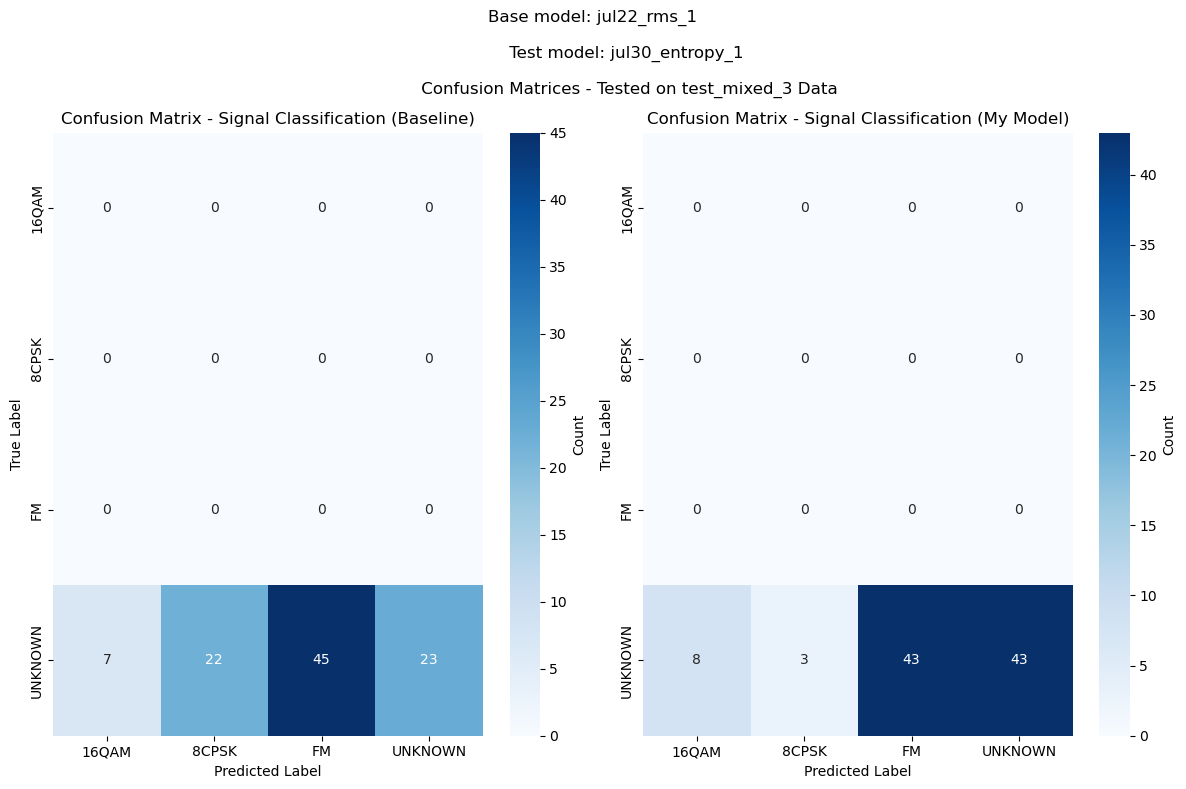

In [83]:

# Plot confusion matrix
plt.figure(figsize=(12, 8))
plt.suptitle(f"""Base model: {model_baseline_name} \n
             Test model: {model_test_name} \n
             Confusion Matrices - Tested on {test_folder} Data""")

plt.subplot(1, 2, 1)
sns.heatmap(df_cm_baseline, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Signal Classification (Baseline)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

plt.subplot(1, 2, 2)
sns.heatmap(df_cm_test, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Signal Classification (My Model)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

plt.show()


In [84]:
for i in range(len(df_test['signal_type'])):
    print(f"Baseline Record {i+1}: {df_test['signal_type'].iloc[i]}, Predicted: {predicted_classes_baseline[i]}, Probability: {highest_probabilities_baseline[i]:.4f}")
    print(f"Test Record {i+1} {df_test['signal_type'].iloc[i]}, Predicted: {predicted_classes_test[i]}, Probability: {highest_probabilities_test[i]:.4f}")

Baseline Record 1: BNET, Predicted: 3, Probability: 0.8957
Test Record 1 BNET, Predicted: 3, Probability: 0.5297
Baseline Record 2: BNET, Predicted: 1, Probability: 0.9150
Test Record 2 BNET, Predicted: 0, Probability: 0.9744
Baseline Record 3: THALES, Predicted: 2, Probability: 0.9998
Test Record 3 THALES, Predicted: 2, Probability: 0.9898
Baseline Record 4: 940, Predicted: 2, Probability: 0.9993
Test Record 4 940, Predicted: 2, Probability: 1.0000
Baseline Record 5: THALES, Predicted: 2, Probability: 1.0000
Test Record 5 THALES, Predicted: 2, Probability: 1.0000
Baseline Record 6: THALES, Predicted: 2, Probability: 0.9996
Test Record 6 THALES, Predicted: 3, Probability: 0.5534
Baseline Record 7: BNET, Predicted: 2, Probability: 0.9782
Test Record 7 BNET, Predicted: 3, Probability: 0.3903
Baseline Record 8: BNET, Predicted: 1, Probability: 0.9125
Test Record 8 BNET, Predicted: 3, Probability: 0.5010
Baseline Record 9: 940, Predicted: 0, Probability: 1.0000
Test Record 9 940, Predicted

### Result analysis and saving

In [85]:
# Comparative Misclassification Analysis for Both Models

def analyze_misclassifications(predicted_classes, model_name, cm_pred):
    """Analyze misclassifications for a given model"""
    print(f"\n{'='*80}")
    print(f"MISCLASSIFICATION ANALYSIS - {model_name.upper()}")
    print(f"{'='*80}")
    
    # Find indices where predictions are wrong
    wrong_predictions = predicted_classes != true_classes
    wrong_indices = np.where(wrong_predictions)[0]
    accuracy = (~wrong_predictions).mean()
    
    print(f"Total samples: {len(true_classes)}")
    print(f"Correct predictions: {(~wrong_predictions).sum()}")
    print(f"Wrong predictions: {wrong_predictions.sum()}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Error rate: {wrong_predictions.mean():.4f}")
    
    # Analyze misclassification patterns
    print(f"\nMISCLASSIFICATION PATTERNS:")
    print(f"{'True → Predicted':<20} {'Count':<8} {'% of True Class':<15}")
    print("-" * 50)
    
    for true_idx, true_label in enumerate(tags):
        true_mask = true_classes == true_idx
        true_count = true_mask.sum()
        
        if true_count > 0:
            for pred_idx, pred_label in enumerate(tags):
                if true_idx != pred_idx:  # Only show wrong predictions
                    wrong_mask = wrong_predictions & true_mask & (predicted_classes == pred_idx)
                    wrong_count = wrong_mask.sum()
                    
                    if wrong_count > 0:
                        percentage = (wrong_count / true_count) * 100
                        print(f"{true_label} → {pred_label:<12} {wrong_count:<8} {percentage:<15.1f}%")
    
    # Get detailed information about misclassified samples
    misclassified_data = []
    for idx in wrong_indices:
        highest_prob = np.max(cm_pred[idx])
        sample_info = {
            'index': idx,
            'true_class': true_classes[idx],
            'true_label': tags[true_classes[idx]],
            'predicted_class': predicted_classes[idx], 
            'predicted_label': tags[predicted_classes[idx]],
            'confidence': highest_prob,
            'signal_type': df_test.iloc[idx]['signal_type'],
            'location': df_test.iloc[idx]['location']
        }
        misclassified_data.append(sample_info)
    
    # Sort by confidence (most confident wrong predictions first)
    misclassified_data.sort(key=lambda x: x['confidence'], reverse=True)
    
    print(f"\nTOP 10 MOST CONFIDENT WRONG PREDICTIONS:")
    print(f"{'Idx':<5} {'True':<8} {'Pred':<8} {'Conf':<8} {'Signal':<12} {'Location':<12}")
    print("-" * 70)
    
    for i, sample in enumerate(misclassified_data[:10]):
        print(f"{sample['index']:<5} {sample['true_label']:<8} {sample['predicted_label']:<8} "
              f"{sample['confidence']:<8.3f} {sample['signal_type']:<12} {sample['location']:<12}")
    
    # Create a DataFrame for easier analysis
    df_misclassified = pd.DataFrame(misclassified_data)
    
    print(f"\nMISCLASSIFICATION BY SIGNAL TYPE AND LOCATION:")
    if len(df_misclassified) > 0:
        misclass_summary = df_misclassified.groupby(['signal_type', 'location']).agg({
            'index': 'count',
            'confidence': 'mean'
        }).round(3)
        misclass_summary.columns = ['Count', 'Avg_Confidence']
        print(misclass_summary)
    else:
        print("No misclassifications found!")
    
    return accuracy, misclassified_data

# Analyze both models
accuracy_baseline, misclassified_baseline = analyze_misclassifications(
    predicted_classes_baseline, "BASELINE MODEL", cm_pred_baseline
)

accuracy_test, misclassified_test = analyze_misclassifications(
    predicted_classes_test, "TEST MODEL", cm_pred_test
)

# Compare models
print(f"\n{'='*80}")
print(f"MODEL COMPARISON SUMMARY")
print(f"{'='*80}")
print(f"{'Model':<15} {'Accuracy':<12} {'Error Rate':<12} {'Misclassified':<15}")
print("-" * 60)
print(f"{'Baseline':<15} {accuracy_baseline:<12.4f} {(1-accuracy_baseline):<12.4f} {len(misclassified_baseline):<15}")
print(f"{'Test':<15} {accuracy_test:<12.4f} {(1-accuracy_test):<12.4f} {len(misclassified_test):<15}")

# Calculate improvement
improvement = accuracy_test - accuracy_baseline
print(f"\nAccuracy Improvement: {improvement:+.4f} ({improvement*100:+.2f}%)")


MISCLASSIFICATION ANALYSIS - BASELINE MODEL
Total samples: 97
Correct predictions: 23
Wrong predictions: 74
Accuracy: 0.2371
Error rate: 0.7629

MISCLASSIFICATION PATTERNS:
True → Predicted     Count    % of True Class
--------------------------------------------------
UNKNOWN → 16QAM        7        7.2            %
UNKNOWN → 8CPSK        22       22.7           %
UNKNOWN → FM           45       46.4           %

TOP 10 MOST CONFIDENT WRONG PREDICTIONS:
Idx   True     Pred     Conf     Signal       Location    
----------------------------------------------------------------------
8     UNKNOWN  16QAM    1.000    940          F87M        
11    UNKNOWN  FM       1.000    THALES       F70M        
13    UNKNOWN  FM       1.000    940          F88M7       
18    UNKNOWN  FM       1.000    THALES       F70M        
19    UNKNOWN  FM       1.000    THALES       F70M        
21    UNKNOWN  FM       1.000    THALES       F70M        
26    UNKNOWN  16QAM    1.000    940          F87M      

In [65]:
# Comparative Evaluation Metrics for Both Models
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report

def evaluate_model(predicted_classes, model_name):
    """Calculate and display evaluation metrics for a model"""
    labels = [0, 1, 2, 3]
    
    # Calculate evaluation metrics
    accuracy = (predicted_classes == true_classes).mean()
    f1 = f1_score(true_classes, predicted_classes, average='weighted', labels=labels, zero_division=0)
    recall = recall_score(true_classes, predicted_classes, average='weighted', labels=labels, zero_division=0)
    precision = precision_score(true_classes, predicted_classes, average='weighted', labels=labels, zero_division=0)
    
    # Calculate per-class metrics
    f1_per_class = f1_score(true_classes, predicted_classes, average=None, labels=labels, zero_division=0)
    recall_per_class = recall_score(true_classes, predicted_classes, average=None, labels=labels, zero_division=0)
    precision_per_class = precision_score(true_classes, predicted_classes, average=None, labels=labels, zero_division=0)
    
    print(f"\n{'='*70}")
    print(f"EVALUATION RESULTS - {model_name.upper()}")
    print(f"{'='*70}")
    print(f"Test Dataset: {pred_store_path}")
    print(f"Date: {pd.Timestamp.now().strftime('%B %d, %Y')}")
    print(f"Total Test Samples: {len(true_classes)}")
    print(f"Threshold: {threshold}")
    print("-"*70)
    
    print(f"\nOVERALL METRICS:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    
    print(f"\nPER-CLASS METRICS:")
    for i, signal_type in enumerate(tags):
        count = (true_classes == i).sum()
        print(f"{signal_type:>8}: F1={f1_per_class[i]:.3f}, Recall={recall_per_class[i]:.3f}, Precision={precision_per_class[i]:.3f}, Count={count}")
    
    print(f"\nDETAILED CLASSIFICATION REPORT:")
    print(classification_report(true_classes, predicted_classes, target_names=tags, labels=labels, zero_division=0))
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'recall': recall,
        'precision': precision,
        'f1_per_class': f1_per_class,
        'recall_per_class': recall_per_class,
        'precision_per_class': precision_per_class
    }

# Evaluate both models
baseline_metrics = evaluate_model(predicted_classes_baseline, "BASELINE MODEL")
test_metrics = evaluate_model(predicted_classes_test, "TEST MODEL")

# Create comparison table
print(f"\n{'='*80}")
print(f"COMPARATIVE METRICS SUMMARY")
print(f"{'='*80}")
print(f"{'Metric':<15} {'Baseline':<12} {'Test Model':<12} {'Improvement':<15}")
print("-" * 65)

metrics_to_compare = ['accuracy', 'f1', 'recall', 'precision']
for metric in metrics_to_compare:
    baseline_val = baseline_metrics[metric]
    test_val = test_metrics[metric]
    improvement = test_val - baseline_val
    print(f"{metric.capitalize():<15} {baseline_val:<12.4f} {test_val:<12.4f} {improvement:+12.4f}")

print(f"\n{'='*80}")
print(f"PER-CLASS COMPARISON")
print(f"{'='*80}")
print(f"{'Class':<10} {'Metric':<10} {'Baseline':<10} {'Test':<10} {'Improvement':<12}")
print("-" * 65)

for i, signal_type in enumerate(tags):
    for metric in ['f1', 'recall', 'precision']:
        baseline_val = baseline_metrics[f'{metric}_per_class'][i]
        test_val = test_metrics[f'{metric}_per_class'][i]
        improvement = test_val - baseline_val
        print(f"{signal_type:<10} {metric.upper():<10} {baseline_val:<10.3f} {test_val:<10.3f} {improvement:+12.3f}")
    print("-" * 65)



EVALUATION RESULTS - BASELINE MODEL
Test Dataset: C:/Users/UserAdmin/Desktop/Jason - Signal Classification/AI Models/Data/test_datasets/test_mixed_3
Date: July 30, 2025
Total Test Samples: 97
Threshold: 0.9
----------------------------------------------------------------------

OVERALL METRICS:
Accuracy:  0.2371
F1 Score:  0.3833
Recall:    0.2371
Precision: 1.0000

PER-CLASS METRICS:
   16QAM: F1=0.000, Recall=0.000, Precision=0.000, Count=0
   8CPSK: F1=0.000, Recall=0.000, Precision=0.000, Count=0
      FM: F1=0.000, Recall=0.000, Precision=0.000, Count=0
 UNKNOWN: F1=0.383, Recall=0.237, Precision=1.000, Count=97

DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       16QAM       0.00      0.00      0.00         0
       8CPSK       0.00      0.00      0.00         0
          FM       0.00      0.00      0.00         0
     UNKNOWN       1.00      0.24      0.38        97

    accuracy                           0.24        97
   macro avg   

Saves evaluation results to JSON

In [66]:
# Save evaluation results to JSON
import json
from datetime import datetime

def save_evaluation_metrics_to_json():
    """Save evaluation metrics comparison to JSON file"""
    
    # Prepare evaluation results dictionary
    evaluation_results = {
        "metadata": {
            "timestamp": datetime.now().isoformat(),
            "test_dataset_path": pred_store_path,
            "total_test_samples": len(true_classes),
            "threshold": threshold,
            "signal_classes": tags,
            "model_paths": {
                "baseline": f"C:/Users/UserAdmin/Desktop/Jason - Signal Classification/AI Models/trained_models/{model_baseline_name}",
                "test": f"C:/Users/UserAdmin/Desktop/Jason - Signal Classification/AI Models/trained_models/{model_test_name}"
            }
        },
        
        "overall_metrics": {
            "baseline": {
                "accuracy": float(baseline_metrics['accuracy']),
                "f1_score": float(baseline_metrics['f1']),
                "recall": float(baseline_metrics['recall']),
                "precision": float(baseline_metrics['precision'])
            },
            "test": {
                "accuracy": float(test_metrics['accuracy']),
                "f1_score": float(test_metrics['f1']),
                "recall": float(test_metrics['recall']),
                "precision": float(test_metrics['precision'])
            },
            "improvements": {}
        },
        
        "per_class_metrics": {
            "baseline": {},
            "test": {},
            "improvements": {}
        },
        
        "sample_counts": {}
    }
    
    # Calculate overall improvements
    metrics_to_compare = ['accuracy', 'f1', 'recall', 'precision']
    for metric in metrics_to_compare:
        baseline_val = baseline_metrics[metric.replace('_score', '')]
        test_val = test_metrics[metric.replace('_score', '')]
        improvement = test_val - baseline_val
        
        evaluation_results["overall_metrics"]["improvements"][f"{metric}_delta"] = float(improvement)
        evaluation_results["overall_metrics"]["improvements"][f"{metric}_percent_change"] = float(improvement * 100)
    
    # Add per-class metrics and improvements
    for i, signal_type in enumerate(tags):
        sample_count = int((true_classes == i).sum())
        evaluation_results["sample_counts"][signal_type] = sample_count
        
        # Baseline per-class metrics
        evaluation_results["per_class_metrics"]["baseline"][signal_type] = {
            "f1_score": float(baseline_metrics['f1_per_class'][i]),
            "recall": float(baseline_metrics['recall_per_class'][i]),
            "precision": float(baseline_metrics['precision_per_class'][i])
        }
        
        # Test per-class metrics
        evaluation_results["per_class_metrics"]["test"][signal_type] = {
            "f1_score": float(test_metrics['f1_per_class'][i]),
            "recall": float(test_metrics['recall_per_class'][i]),
            "precision": float(test_metrics['precision_per_class'][i])
        }
        
        # Per-class improvements
        evaluation_results["per_class_metrics"]["improvements"][signal_type] = {
            "f1_delta": float(test_metrics['f1_per_class'][i] - baseline_metrics['f1_per_class'][i]),
            "recall_delta": float(test_metrics['recall_per_class'][i] - baseline_metrics['recall_per_class'][i]),
            "precision_delta": float(test_metrics['precision_per_class'][i] - baseline_metrics['precision_per_class'][i])
        }
    
    # Generate filename with timestamp
    timestamp = datetime.now().strftime("%m%d_%H%M")
    filename = f"evaluation_metrics_comparison_{timestamp}_{model_baseline_name}_{model_test_name}_{test_folder}.json"
    filepath = f"C:/Users/UserAdmin/Desktop/Jason - Signal Classification/AI Models/Results/{filename}"
    
    # Save to JSON file
    try:
        with open(filepath, 'w') as f:
            json.dump(evaluation_results, f, indent=2, ensure_ascii=False)
        
        print(f"\n{'='*80}")
        print(f"✅ EVALUATION METRICS SAVED TO JSON")
        print(f"{'='*80}")
        print(f"File: {filepath}")
        print(f"Size: {len(json.dumps(evaluation_results, indent=2))} characters")
        
        print(f"\nFile contains:")
        print(f"• Overall metrics for both models (accuracy, F1, recall, precision)")
        print(f"• Per-class metrics for all {len(tags)} signal types")
        print(f"• Improvement calculations (deltas and percent changes)")
        print(f"• Sample counts and metadata")
        
        print(f"\nKey improvements saved:")
        for metric in metrics_to_compare:
            improvement = evaluation_results["overall_metrics"]["improvements"][f"{metric}_delta"]
            print(f"• {metric.capitalize()}: {improvement:+.4f}")
            
        return filepath, evaluation_results
        
    except Exception as e:
        print(f"❌ Error saving evaluation metrics: {str(e)}")
        return None, evaluation_results

# Call the function to save metrics
print(f"\n{'='*80}")
print(f"SAVING EVALUATION METRICS TO JSON")
print(f"{'='*80}")

saved_metrics_path, metrics_data = save_evaluation_metrics_to_json()

if saved_metrics_path:
    print(f"\n✅ Successfully saved evaluation metrics!")
    print(f"📁 Location: {saved_metrics_path}")
else:
    print(f"\n❌ Failed to save evaluation metrics.")




SAVING EVALUATION METRICS TO JSON

✅ EVALUATION METRICS SAVED TO JSON
File: C:/Users/UserAdmin/Desktop/Jason - Signal Classification/AI Models/Results/evaluation_metrics_comparison_0730_2148_jul22_rms_1_jul30_entropy_1_test_mixed_3.json
Size: 2835 characters

File contains:
• Overall metrics for both models (accuracy, F1, recall, precision)
• Per-class metrics for all 4 signal types
• Improvement calculations (deltas and percent changes)
• Sample counts and metadata

Key improvements saved:
• Accuracy: +0.2062
• F1: +0.2310
• Recall: +0.2062
• Precision: +0.0000

✅ Successfully saved evaluation metrics!
📁 Location: C:/Users/UserAdmin/Desktop/Jason - Signal Classification/AI Models/Results/evaluation_metrics_comparison_0730_2148_jul22_rms_1_jul30_entropy_1_test_mixed_3.json


Calibration Analysis

IndexError: index 3 is out of bounds for axis 1 with size 3

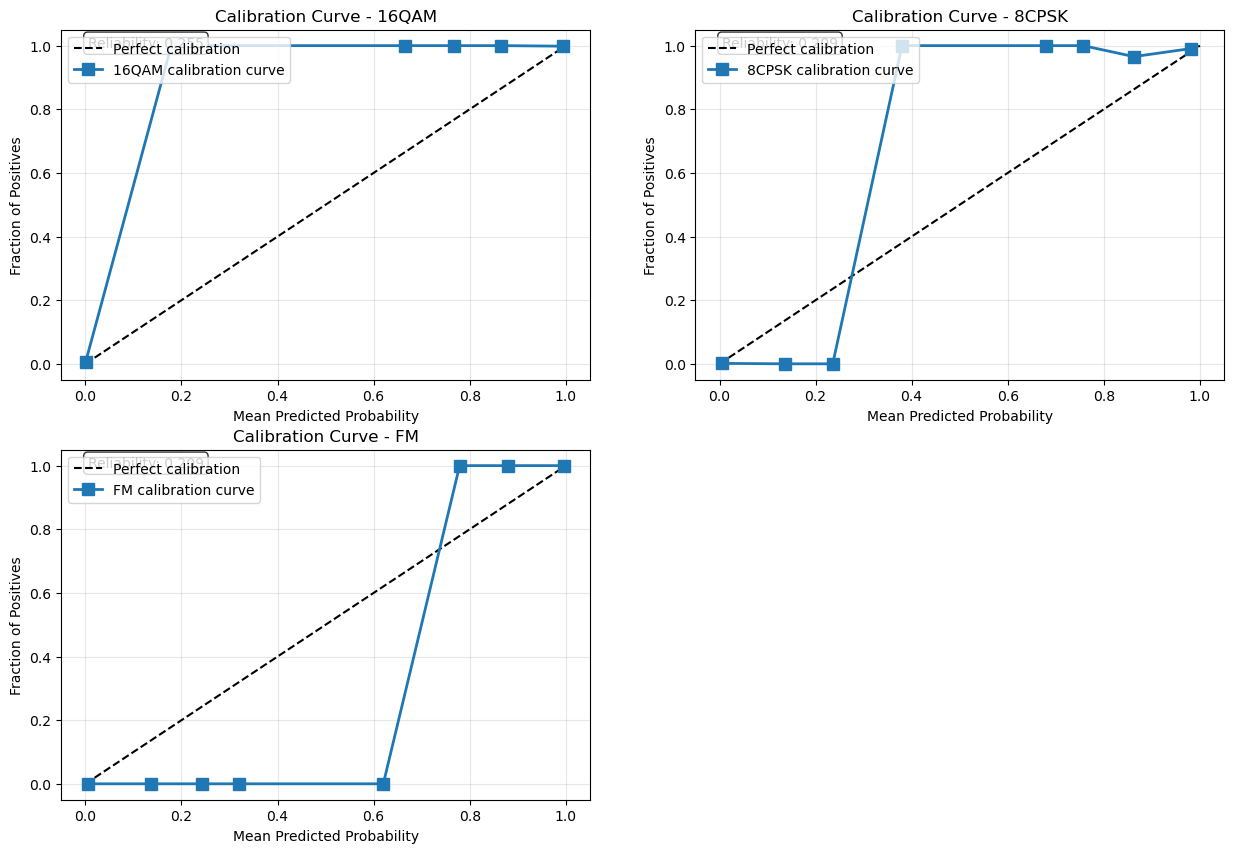

In [53]:
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import label_binarize

# Plot calibration curves for each class
plt.figure(figsize=(15, 10))

# For multiclass, we need to create binary classification problems for each class
y_true_binary = label_binarize(true_classes, classes=list(range(len(tags))))

# Plot calibration curve for each class
for i, class_name in enumerate(tags):
    # Get the predicted probabilities for this class
    y_prob_class = cm_pred_test[:, i]
    
    # Get the true binary labels for this class (1 if true class, 0 otherwise)
    y_true_class = y_true_binary[:, i]
    
    # Calculate calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true_class, y_prob_class, n_bins=10, strategy='uniform'
    )
    
    # Plot calibration curve for this class
    plt.subplot(2, 2, i+1)
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
    plt.plot(mean_predicted_value, fraction_of_positives, 's-', 
             label=f'{class_name} calibration curve', linewidth=2, markersize=8)
    
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(f'Calibration Curve - {class_name}')
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # Add text showing calibration statistics
    reliability = np.mean(np.abs(fraction_of_positives - mean_predicted_value))
    plt.text(0.05, 0.95, f'Reliability: {reliability:.3f}', 
             transform=plt.gca().transAxes, fontsize=10,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Calculate overall calibration statistics
print("\nCALIBRATION STATISTICS:")
print("="*50)

overall_reliability_scores = []
for i, class_name in enumerate(tags):
    y_prob_class = cm_pred_test[:, i]
    y_true_class = y_true_binary[:, i]
    
    if len(np.unique(y_true_class)) > 1:  # Only calculate if class exists in true labels
        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_true_class, y_prob_class, n_bins=10, strategy='uniform'
        )
        
        # Calculate reliability (lower is better, 0 is perfect)
        reliability = np.mean(np.abs(fraction_of_positives - mean_predicted_value))
        overall_reliability_scores.append(reliability)
        
        # Calculate resolution (higher is better)
        resolution = np.mean((fraction_of_positives - np.mean(y_true_class))**2)
        
        # Calculate Brier score (lower is better)
        brier_score = np.mean((y_prob_class - y_true_class)**2)
        
        print(f"{class_name:>8}: Reliability={reliability:.4f}, Resolution={resolution:.4f}, Brier Score={brier_score:.4f}")
    else:
        print(f"{class_name:>8}: No samples in test set")

if overall_reliability_scores:
    mean_reliability = np.mean(overall_reliability_scores)
    print(f"\nOverall Mean Reliability: {mean_reliability:.4f}")
    
    # Interpret calibration quality
    if mean_reliability < 0.05:
        calibration_quality = "Excellent"
    elif mean_reliability < 0.10:
        calibration_quality = "Good"
    elif mean_reliability < 0.15:
        calibration_quality = "Fair"
    else:
        calibration_quality = "Poor"
    
    print(f"Calibration Quality: {calibration_quality}")
    print("\nInterpretation:")
    print("- Reliability < 0.05: Excellent calibration")
    print("- Reliability < 0.10: Good calibration") 
    print("- Reliability < 0.15: Fair calibration")
    print("- Reliability ≥ 0.15: Poor calibration")

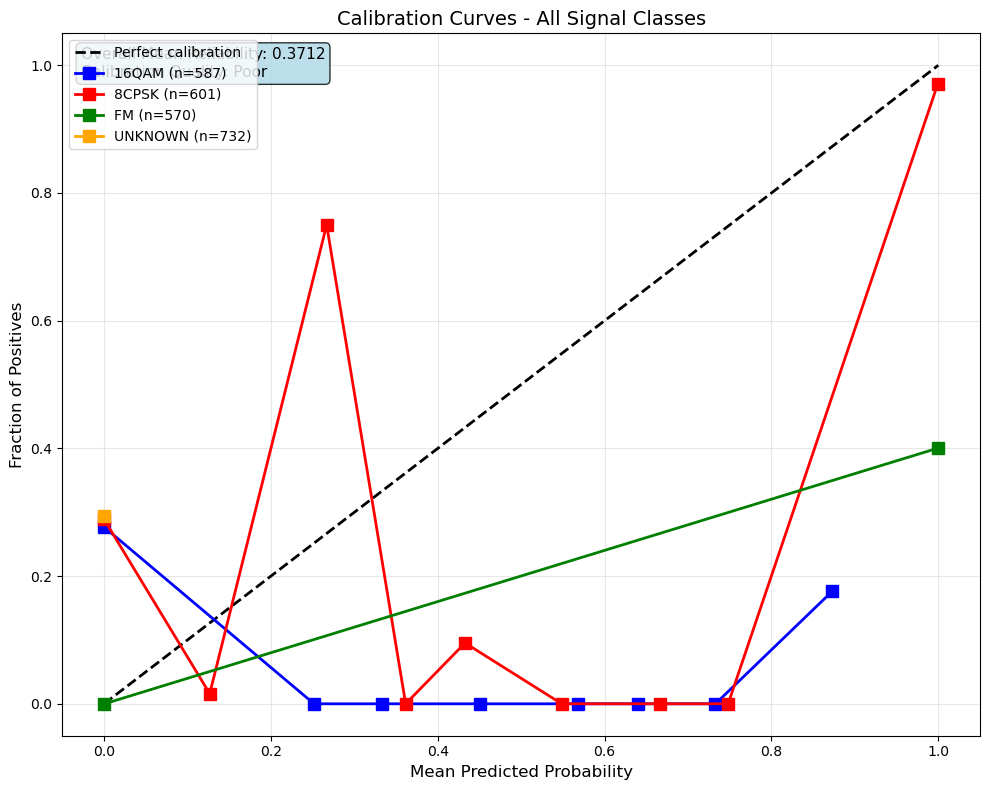


EXPECTED CALIBRATION ERROR (ECE):
Overall ECE: 0.5924
ECE Interpretation:
- ECE < 0.05: Well calibrated
- ECE < 0.10: Reasonably calibrated
- ECE ≥ 0.10: Poorly calibrated

CALIBRATION BY CONFIDENCE BINS:
Confidence Range     Count    Accuracy   Avg Confidence  Difference  
---------------------------------------------------------------------------
0.0 - 0.1         0        N/A        N/A             N/A         
0.1 - 0.2         0        N/A        N/A             N/A         
0.2 - 0.3         0        N/A        N/A             N/A         
0.3 - 0.4         0        N/A        N/A             N/A         
0.4 - 0.5         0        N/A        N/A             N/A         
0.5 - 0.6         28       0.000      0.564           0.564       
0.6 - 0.7         31       0.000      0.640           0.640       
0.7 - 0.8         11       0.000      0.737           0.737       
0.8 - 0.9         823      0.176      0.873           0.697       
0.9 - 1.0         1597     0.463      1.000  

In [ ]:
# Combined calibration curve showing all classes
plt.figure(figsize=(10, 8))

# Plot perfect calibration line
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect calibration')

# Color palette for different classes
colors = ['blue', 'red', 'green', 'orange']

# Plot calibration curve for each class on the same plot
for i, class_name in enumerate(tags):
    y_prob_class = cm_pred[:, i]
    y_true_class = y_true_binary[:, i]
    
    if len(np.unique(y_true_class)) > 1:  # Only plot if class exists in true labels
        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_true_class, y_prob_class, n_bins=10, strategy='uniform'
        )
        
        plt.plot(mean_predicted_value, fraction_of_positives, 's-', 
                 color=colors[i % len(colors)], linewidth=2, markersize=8,
                 label=f'{class_name} (n={(y_true_class == 1).sum()})')

plt.xlabel('Mean Predicted Probability', fontsize=12)
plt.ylabel('Fraction of Positives', fontsize=12)
plt.title('Calibration Curves - All Signal Classes', fontsize=14)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)

# Add overall statistics as text
plt.text(0.02, 0.98, f'Overall Mean Reliability: {mean_reliability:.4f}\nCalibration Quality: {calibration_quality}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()

# Additional calibration analysis: Expected Calibration Error (ECE)
def expected_calibration_error(y_true, y_prob, n_bins=10):
    """
    Calculate Expected Calibration Error (ECE)
    ECE measures the difference between accuracy and confidence across all predictions
    """
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    ece = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Find predictions in this bin
        in_bin = (y_prob > bin_lower) & (y_prob <= bin_upper)
        prop_in_bin = in_bin.mean()
        
        if prop_in_bin > 0:
            accuracy_in_bin = y_true[in_bin].mean()
            avg_confidence_in_bin = y_prob[in_bin].mean()
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    
    return ece

# Calculate ECE for the overall model (using max probability predictions)
max_probs = np.max(cm_pred, axis=1)
correct_predictions = (predicted_classes == true_classes).astype(int)
overall_ece = expected_calibration_error(correct_predictions, max_probs)

print(f"\nEXPECTED CALIBRATION ERROR (ECE):")
print(f"Overall ECE: {overall_ece:.4f}")
print(f"ECE Interpretation:")
print(f"- ECE < 0.05: Well calibrated")
print(f"- ECE < 0.10: Reasonably calibrated")
print(f"- ECE ≥ 0.10: Poorly calibrated")

# Show calibration by confidence bins
print(f"\nCALIBRATION BY CONFIDENCE BINS:")
print(f"{'Confidence Range':<20} {'Count':<8} {'Accuracy':<10} {'Avg Confidence':<15} {'Difference':<12}")
print("-" * 75)

n_bins = 10
bin_boundaries = np.linspace(0, 1, n_bins + 1)
for i in range(n_bins):
    bin_lower = bin_boundaries[i]
    bin_upper = bin_boundaries[i + 1]
    
    in_bin = (max_probs > bin_lower) & (max_probs <= bin_upper)
    count_in_bin = in_bin.sum()
    
    if count_in_bin > 0:
        accuracy_in_bin = correct_predictions[in_bin].mean()
        avg_confidence_in_bin = max_probs[in_bin].mean()
        difference = abs(avg_confidence_in_bin - accuracy_in_bin)
        
        print(f"{bin_lower:.1f} - {bin_upper:.1f}         {count_in_bin:<8} {accuracy_in_bin:<10.3f} {avg_confidence_in_bin:<15.3f} {difference:<12.3f}")
    else:
        print(f"{bin_lower:.1f} - {bin_upper:.1f}         {count_in_bin:<8} {'N/A':<10} {'N/A':<15} {'N/A':<12}")

## Identifying unknowns using Mahalanobis Detector

### OOD Detector definition

Mahalanobis Detector class

In [54]:
from scipy import linalg
from sklearn.covariance import EmpiricalCovariance, LedoitWolf
import pickle
import json

class MahalanobisOODDetector:
    """
    Mahalanobis distance-based Out-of-Distribution detector for neural networks.
    
    Based on "A Simple Unified Framework for Detecting Out-of-Distribution Samples 
    and Adversarial Attacks" (Lee et al., 2018)
    """
    
    def __init__(self, use_tied_cov=True, cov_estimator='ledoit_wolf'):
        """
        Initialize Mahalanobis OOD detector.
        
        Args:
            use_tied_cov: If True, use pooled covariance across all classes
            cov_estimator: 'empirical' or 'ledoit_wolf' for covariance estimation
        """
        self.use_tied_cov = use_tied_cov
        self.cov_estimator = cov_estimator
        self.class_means = {}
        self.class_covs = {}
        self.pooled_cov = None
        self.inv_covs = {}
        self.fitted = False
        self.known_classes = None
        self.threshold = None
        
    def fit(self, features, labels, class_names, validation_features=None, validation_labels=None):
        """
        Fit the Mahalanobis detector using training features.
        
        Args:
            features: Training features from penultimate layer, shape (n_samples, n_features)
            labels: Training labels, shape (n_samples,)
            class_names: List of class names corresponding to label indices
            validation_features: Optional validation features for threshold calculation
            validation_labels: Optional validation labels for threshold calculation
        """
        print("=" * 60)
        print("FITTING MAHALANOBIS OOD DETECTOR")
        print("=" * 60)
        
        self.known_classes = class_names
        unique_labels = np.unique(labels)
        
        print(f"Known classes: {class_names}")
        print(f"Feature dimension: {features.shape[1]}")
        print(f"Total training samples: {features.shape[0]}")
        
        # Calculate class-conditional means
        print(f"\nCalculating class-conditional means...")
        for label in unique_labels:
            if label < len(class_names):  # Only process known classes
                class_mask = labels == label
                class_features = features[class_mask]
                self.class_means[label] = np.mean(class_features, axis=0)
                
                print(f"  {class_names[label]}: {class_features.shape[0]} samples")
        
        # Calculate covariance matrices
        print(f"\nCalculating covariance matrices...")
        if self.use_tied_cov:
            # Use pooled covariance across all known classes
            all_known_features = []
            
            for label in unique_labels:
                if label < len(class_names):  # Only known classes
                    class_mask = labels == label
                    class_features = features[class_mask]
                    all_known_features.append(class_features)
            
            all_known_features = np.vstack(all_known_features)
            
            # Estimate pooled covariance
            if self.cov_estimator == 'ledoit_wolf':
                print("  Using Ledoit-Wolf covariance estimation...")
                cov_estimator = LedoitWolf()
                cov_estimator.fit(all_known_features)
                self.pooled_cov = cov_estimator.covariance_
            else:
                print("  Using empirical covariance estimation...")
                self.pooled_cov = np.cov(all_known_features.T)
            
            # Use same covariance for all classes
            for label in unique_labels:
                if label < len(class_names):
                    self.class_covs[label] = self.pooled_cov
            
            print(f"  Tied covariance matrix shape: {self.pooled_cov.shape}")
            
        else:
            # Use class-specific covariances
            print("  Using class-specific covariances...")
            for label in unique_labels:
                if label < len(class_names):
                    class_mask = labels == label
                    class_features = features[class_mask]
                    
                    if self.cov_estimator == 'ledoit_wolf':
                        cov_estimator = LedoitWolf()
                        cov_estimator.fit(class_features)
                        self.class_covs[label] = cov_estimator.covariance_
                    else:
                        self.class_covs[label] = np.cov(class_features.T)
        
        # Compute inverse covariances for efficiency
        print(f"\nComputing inverse covariance matrices...")
        for label in self.class_covs:
            try:
                self.inv_covs[label] = linalg.inv(self.class_covs[label])
                print(f"  {class_names[label]}: Successfully inverted")
            except linalg.LinAlgError:
                # Use pseudo-inverse if matrix is singular
                self.inv_covs[label] = linalg.pinv(self.class_covs[label])
                print(f"  {class_names[label]}: Using pseudo-inverse (singular matrix)")
        
        # Calculate threshold using validation data if provided
        if validation_features is not None and validation_labels is not None:
            print(f"\nCalculating optimal threshold using validation data...")
            val_distances = self._compute_min_distances(validation_features)
            self.threshold = np.percentile(val_distances, 95)
            print(f"  Threshold (95th percentile): {self.threshold:.4f}")
        else:
            # Use training data for threshold calculation
            print(f"\nCalculating threshold using training data...")
            train_distances = self._compute_min_distances(features)
            self.threshold = np.percentile(train_distances, 95)
            print(f"  Threshold (95th percentile): {self.threshold:.4f}")
        
        self.fitted = True
        print(f"\n✅ Mahalanobis OOD detector fitted successfully!")
        
        return self
    
    def _compute_min_distances(self, features):
        """Compute minimum Mahalanobis distances across all classes"""
        if not self.fitted and len(self.class_means) == 0:
            raise ValueError("Detector must be fitted before computing distances")
        
        n_samples = features.shape[0]
        distances = {}
        
        # Compute Mahalanobis distance to each class
        for label in self.class_means:
            class_mean = self.class_means[label]
            inv_cov = self.inv_covs[label]
            
            # Center the features
            centered_features = features - class_mean
            
            # Compute Mahalanobis distance: sqrt((x-μ)^T Σ^(-1) (x-μ))
            mahal_dist = np.sqrt(np.sum(centered_features @ inv_cov * centered_features, axis=1))
            distances[label] = mahal_dist
        
        # Find minimum distance across all classes
        distance_matrix = np.stack(list(distances.values()), axis=1)
        min_distances = np.min(distance_matrix, axis=1)
        
        return min_distances
    
    def predict_ood(self, features, threshold=None):
        """
        Predict out-of-distribution samples.
        
        Args:
            features: Test features, shape (n_samples, n_features)
            threshold: Mahalanobis distance threshold. If None, uses fitted threshold
            
        Returns:
            ood_predictions: Boolean array, True for OOD samples
            min_distances: Minimum Mahalanobis distances
        """
        if not self.fitted:
            raise ValueError("Detector must be fitted before making predictions")
        
        min_distances = self._compute_min_distances(features)
        
        if threshold is None:
            threshold = self.threshold
        
        ood_predictions = min_distances > threshold
        
        return ood_predictions, min_distances
    
    def save(self, filepath):
        """Save the fitted detector to file"""
        detector_data = {
            'use_tied_cov': self.use_tied_cov,
            'cov_estimator': self.cov_estimator,
            'class_means': {int(k): v.tolist() for k, v in self.class_means.items()},
            'class_covs': {int(k): v.tolist() for k, v in self.class_covs.items()},
            'pooled_cov': self.pooled_cov.tolist() if self.pooled_cov is not None else None,
            'inv_covs': {int(k): v.tolist() for k, v in self.inv_covs.items()},
            'fitted': self.fitted,
            'known_classes': self.known_classes,
            'threshold': float(self.threshold) if self.threshold is not None else None
        }
        
        with open(filepath, 'w') as f:
            json.dump(detector_data, f, indent=2)
        
        print(f"✅ OOD detector saved to: {filepath}")

print("✅ Mahalanobis OOD detector class implemented!")

✅ Mahalanobis OOD detector class implemented!


### Load the trained OOD Detector

In [160]:
# Load Pretrained OOD Detector from JSON
import numpy as np
import pandas as pd
import json
import os
import glob

def load_ood_detector_from_json(detector_path):
    """
    Load a pretrained MahalanobisOODDetector from JSON file.
    
    Args:
        detector_path: Path to the JSON file containing detector parameters
        
    Returns:
        detector: Loaded MahalanobisOODDetector instance
    """
    print(f"Loading OOD detector from: {detector_path}")
    
    try:
        with open(detector_path, 'r') as f:
            detector_data = json.load(f)
        
        # Create detector instance
        detector = MahalanobisOODDetector(
            use_tied_cov=detector_data.get('use_tied_cov', True),
            cov_estimator=detector_data.get('cov_estimator', 'ledoit_wolf')
        )
        
        # Load pretrained parameters
        detector.class_means = {int(k): np.array(v) for k, v in detector_data['class_means'].items()}
        detector.class_covs = {int(k): np.array(v) for k, v in detector_data['class_covs'].items()}
        detector.inv_covs = {int(k): np.array(v) for k, v in detector_data['inv_covs'].items()}
        
        if detector_data['pooled_cov'] is not None:
            detector.pooled_cov = np.array(detector_data['pooled_cov'])
        else:
            detector.pooled_cov = None
            
        detector.fitted = detector_data['fitted']
        detector.known_classes = detector_data['known_classes']
        detector.threshold = detector_data['threshold']
        
        print(f"✅ Successfully loaded OOD detector:")
        print(f"   • Known classes: {detector.known_classes}")
        print(f"   • Feature dimension: {list(detector.class_means.values())[0].shape[0]}")
        print(f"   • Covariance estimator: {detector.cov_estimator}")
        print(f"   • Tied covariance: {detector.use_tied_cov}")
        print(f"   • Detection threshold: {detector.threshold:.4f}")
        
        return detector
        
    except FileNotFoundError:
        print(f"❌ OOD detector file not found: {detector_path}")
        return None
    except Exception as e:
        print(f"❌ Error loading OOD detector: {e}")
        return None



# Load OOD Detector from JSON file
ood_detector_pretained_folder = "C:/Users/UserAdmin/Desktop/Jason - Signal Classification/AI Models/ood_detectors"
ood_detector_pretrained_filename = "mahalanobis_ood_detector_jul25_rms_1_20250726_193658_flatten_layer.json"
ood_detector_pretrained_path = os.path.join(ood_detector_pretained_folder, ood_detector_pretrained_filename)
ood_detector = load_ood_detector_from_json(ood_detector_pretrained_path)

if ood_detector is not None:
    print(f"✅ Primary OOD detector loaded successfully")
    print(f"   • Model: {ood_detector.known_classes}")
else:
    print(f"❌ No OOD detector available")
    print(f"   • Cannot perform OOD detection")
    print(f"   • Run OOD detector training in classifier_training.ipynb first")

Loading OOD detector from: C:/Users/UserAdmin/Desktop/Jason - Signal Classification/AI Models/ood_detectors\mahalanobis_ood_detector_jul25_rms_1_20250726_193658_flatten_layer.json
✅ Successfully loaded OOD detector:
   • Known classes: ['16QAM', '8CPSK', 'FM']
   • Feature dimension: 768
   • Covariance estimator: ledoit_wolf
   • Tied covariance: True
   • Detection threshold: 40.9944
✅ Primary OOD detector loaded successfully
   • Model: ['16QAM', '8CPSK', 'FM']


### Feature Extractor

Method for extracting feature from model

In [332]:
## Extract Features for OOD Detector Training

def extract_features_from_model(model, X_data, layer_name=None):
    """
    Extract features from a specific layer of the model.
    
    Args:
        model: Trained Keras model
        X_data: Input data
        layer_name: Name of layer to extract from. If None, uses penultimate layer
        
    Returns:
        features: Extracted features, shape (n_samples, n_features)
    """
    if layer_name is None:
        # Use penultimate layer (before final classification layer)
        feature_layer = model.layers[-8]
    else:
        feature_layer = model.get_layer(layer_name)
    
    print(f"Extracting features from layer: {feature_layer.name}")
    print(f"Layer output shape: {feature_layer.output_shape}")
    
    # Create feature extraction model
    feature_extractor = tf.keras.Model(
        inputs=model.input,
        outputs=feature_layer.output
    )

    # print(f"\nFeature extractor layers:")
    # for i, layer in enumerate(feature_extractor.layers):
    #     print(f"  {i}: {layer.name} - {type(layer).__name__}")
    
    # Extract features
    features = feature_extractor.predict(X_data, verbose=1)
    
    # Flatten if needed (for dense layers, features might be 2D)
    if len(features.shape) > 2:
        features = features.reshape(features.shape[0], -1)
    
    print(f"Extracted features shape: {features.shape}")
    return features


Extracting features for the baseline model and the test model

In [333]:
print("=" * 80)
print("EXTRACTING FEATURES FOR OOD DETECTION")
print("=" * 80)

# Extract features from baseline model
print("\nExtracting features from BASELINE MODEL...")
print("-" * 50)
baseline_test_features = extract_features_from_model(model_baseline, X_test)

# Extract features from test model  
print("\nExtracting features from TEST MODEL...")
print("-" * 50)
test_test_features = extract_features_from_model(model_test, X_test)

# Display feature extraction summary
print(f"\n{'='*80}")
print("FEATURE EXTRACTION SUMMARY")
print(f"{'='*80}")
print(f"Input data shape: {X_test.shape}")
print(f"Baseline model features shape: {baseline_test_features.shape}")
print(f"Test model features shape: {test_test_features.shape}")

# Verify feature dimensions match
if baseline_test_features.shape[1] == test_test_features.shape[1]:
    print(f"✅ Feature dimensions match: {baseline_test_features.shape[1]} features")
else:
    print(f"⚠️  Feature dimensions differ:")
    print(f"   Baseline: {baseline_test_features.shape[1]} features")
    print(f"   Test: {test_test_features.shape[1]} features")

print(f"\n✅ Feature extraction completed successfully!")
print(f"   • Ready for OOD detection analysis")
print(f"   • Features extracted from penultimate dense layer")

EXTRACTING FEATURES FOR OOD DETECTION

Extracting features from BASELINE MODEL...
--------------------------------------------------
Extracting features from layer: conv2d_58
Layer output shape: (None, 1, 32, 16)
119/119 [==============================] - 15s 121ms/step
Extracted features shape: (3797, 512)

Extracting features from TEST MODEL...
--------------------------------------------------
Extracting features from layer: conv2d_28
Layer output shape: (None, 1, 32, 16)
119/119 [==============================] - 14s 120ms/step
Extracted features shape: (3797, 512)

FEATURE EXTRACTION SUMMARY
Input data shape: (3797, 2, 1024, 1)
Baseline model features shape: (3797, 512)
Test model features shape: (3797, 512)
✅ Feature dimensions match: 512 features

✅ Feature extraction completed successfully!
   • Ready for OOD detection analysis
   • Features extracted from penultimate dense layer


In [253]:
num_rows = test_test_features.shape[1]
num_cols = test_test_features.shape[0]
for row in range(num_cols):
    print(f"{df_test['filename'][row][:15]}", end=' ')
for row in range(num_rows):
    for col in range(test_test_features.shape[0]):
        print(f"{test_test_features[col, row]:<15.4f}", end=' ')
    print()

16qam_f270M_200 16qam_f270M_fs5 64qam_f237M_bne 8cpsk_f70M_fs56 8cpsk_f70M_s200 bnet_f55M_2024. fm_f70M_fs56M_s fm_f70M_s200k_s thales_f70M_tha 0.0000          0.0000          0.0000          0.0000          0.0000          0.0000          0.0000          0.4973          0.0000          
6.7201          4.8862          0.0000          0.0000          0.0000          4.0007          0.0000          0.0000          0.0000          
0.0000          4.8360          6.6090          5.4988          1.7057          9.4060          1.2161          2.4154          0.0000          
2.1418          2.8540          6.9397          3.6143          7.1771          4.7890          4.8572          11.8532         12.3252         
0.0000          0.7517          4.6732          0.0000          5.1645          0.4453          5.7476          11.0243         0.0000          
0.0000          16.5101         0.0883          0.0000          0.0000          0.0000          0.0000          1.6451          0.0

### Energy scoring

NEGATIVE LOG SUM EXP ENERGY SCORING ANALYSIS
🔍 Analyzing BASELINE MODEL negative log sum exp energy scores...

NEGATIVE LOG SUM EXP ENERGY ANALYSIS - BASELINE MODEL
Energy Score Statistics:
  Mean: -559.3995
  Std:  129.0986
  Min:  -846.7692
  Max:  -6.6237
  Range: 840.1454

Per-Class Energy Analysis:
Class      Count    Mean       Std        Min        Max       
-----------------------------------------------------------------
16QAM      1263     -606.6992  119.6669   -846.7692  -100.2789 
8CPSK      919      -531.7650  154.6668   -846.7692  -6.6237   
FM         818      -535.9837  129.1061   -846.7692  -171.6595 
UNKNOWN    797      -540.3415  81.6379    -846.7692  -10.0616  

Statistical Significance Tests (p-values):
Class 1    Class 2    T-test       Mann-Whitney    Interpretation      
--------------------------------------------------------------------------------
16QAM      8CPSK      0.000000     0.000000        Highly Significant  
16QAM      FM         0.000000     0.000

C:\Users\UserAdmin\AppData\Local\Temp\ipykernel_27016\3542366983.py:348: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


<Figure size 1600x1200 with 0 Axes>

c:\Users\UserAdmin\miniconda3\envs\new_tf_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


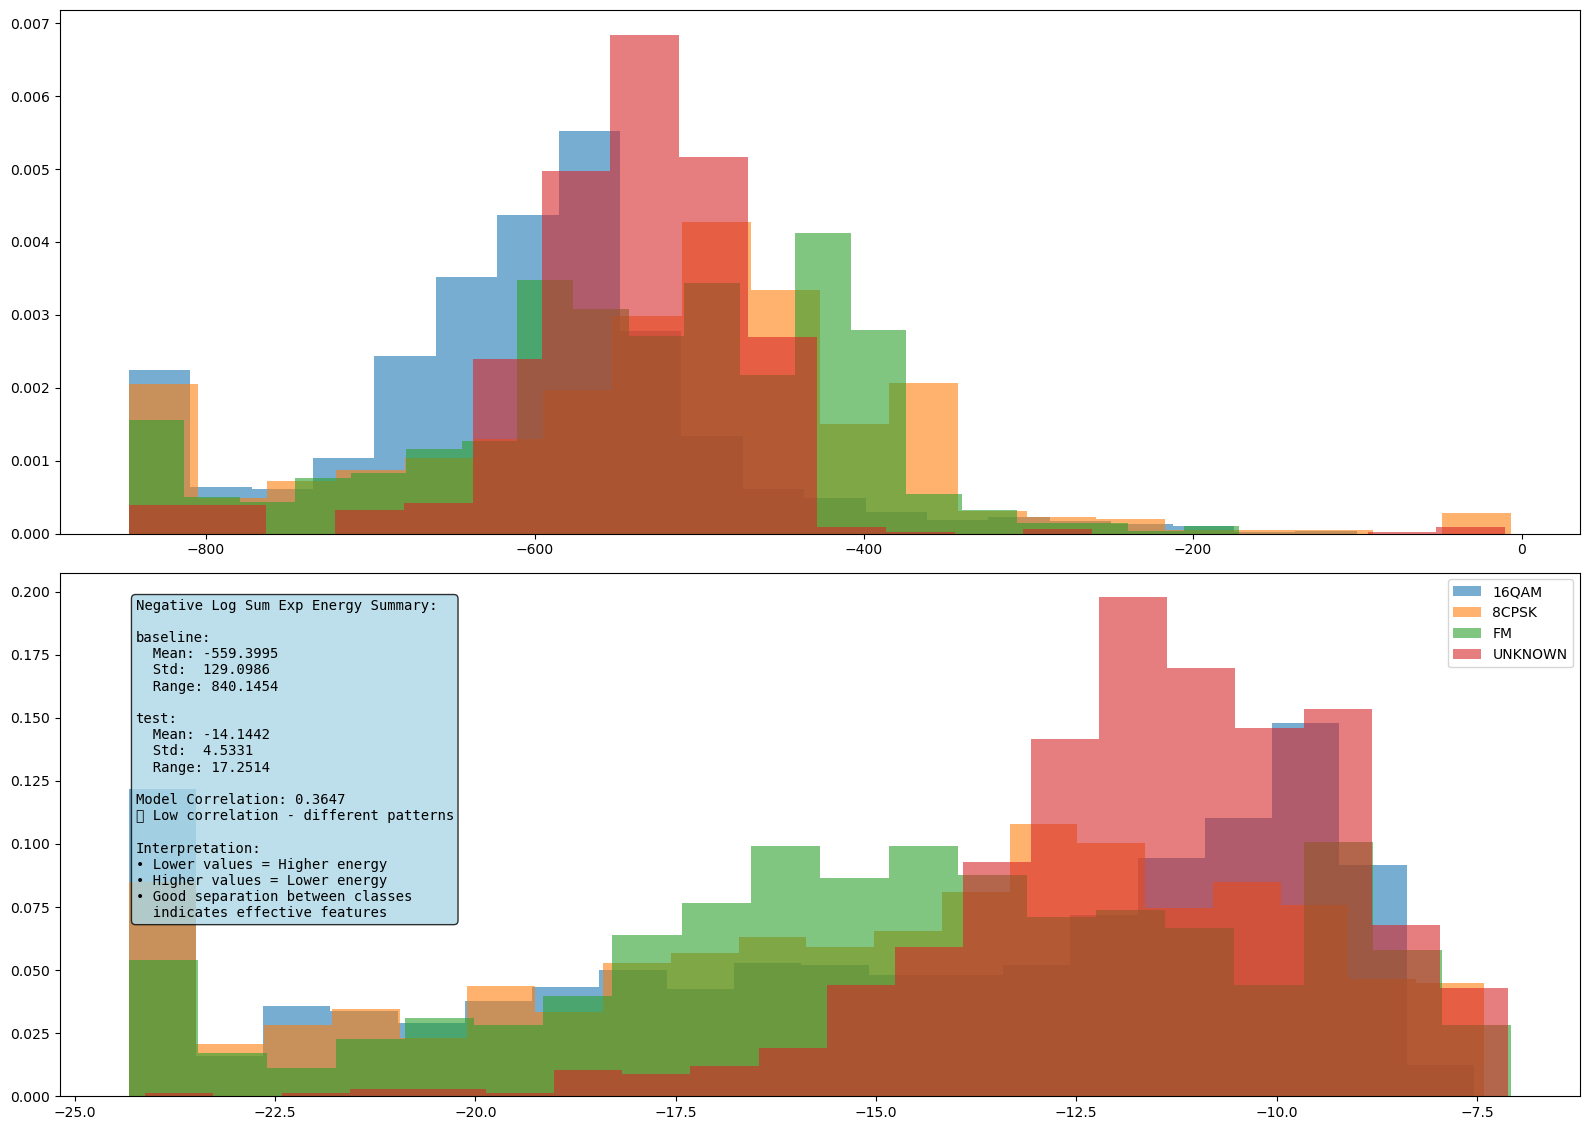


NEGATIVE LOG SUM EXP ENERGY COMPARISON BETWEEN MODELS
MEAN ENERGY SCORES:
  Baseline: -559.3995
  Test:     -14.1442
  Difference: +545.2553

Energy score correlation between models: 0.3647
❌ Low correlation - significant differences in energy patterns

Paired t-test between models: t=-263.4511, p=0.000000
✅ Significant difference in energy patterns between models

✅ Negative log sum exp energy scoring analysis completed!


In [334]:
# Energy Scoring Analysis for Feature Layers

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import classification_report

def compute_energy_score_clipped(features):
    """
    Compute negative log sum exp energy score for feature vectors.
    However, clip the scores to avoid extreme values. 
    """
    # Negative Log Sum Exp energy: -log(sum(exp(x_i)))
    # For numerical stability, use the log-sum-exp trick
    max_vals = np.max(features, axis=1, keepdims=True)
    log_sum_exp = max_vals.flatten() + np.log(np.sum(np.exp(features - max_vals), axis=1))
    # Calculate 95th percentile for clipping
    percentile_95 = np.percentile(log_sum_exp, 95)
    # Clip the scores to avoid extreme values
    energy_scores = -np.clip(log_sum_exp,a_max=percentile_95,a_min=None)
    
    return energy_scores

def compute_energy_score(features):
    """
    Compute negative log sum exp energy score for feature vectors.
    
    Args:
        features: Feature vectors, shape (n_samples, n_features)
    
    Returns:
        energy_scores: Array of negative log sum exp energy scores for each sample
    """
    
    # Negative Log Sum Exp energy: -log(sum(exp(x_i)))
    # For numerical stability, use the log-sum-exp trick
    max_vals = np.max(features, axis=1, keepdims=True)
    # log(sum(exp(x_i))) = max + log(sum(exp(x_i - max)))
    log_sum_exp = max_vals.flatten() + np.log(np.sum(np.exp(features - max_vals), axis=1))
    energy_scores = -log_sum_exp
    
    return energy_scores

def analyze_energy_scores(energy_scores, true_labels, model_name):
    """
    Analyze negative log sum exp energy scores and their relationship to signal classes.
    """
    
    print(f"\n{'='*60}")
    print(f"NEGATIVE LOG SUM EXP ENERGY ANALYSIS - {model_name}")
    print(f"{'='*60}")
    
    # Overall statistics
    print(f"Energy Score Statistics:")
    print(f"  Mean: {np.mean(energy_scores):.4f}")
    print(f"  Std:  {np.std(energy_scores):.4f}")
    print(f"  Min:  {np.min(energy_scores):.4f}")
    print(f"  Max:  {np.max(energy_scores):.4f}")
    print(f"  Range: {np.max(energy_scores) - np.min(energy_scores):.4f}")
    
    # Per-class analysis
    print(f"\nPer-Class Energy Analysis:")
    print(f"{'Class':<10} {'Count':<8} {'Mean':<10} {'Std':<10} {'Min':<10} {'Max':<10}")
    print("-" * 65)
    
    class_stats = {}
    signal_names = ['16QAM', '8CPSK', 'FM', 'UNKNOWN']
    
    for class_idx in range(len(signal_names)):
        class_mask = true_labels == class_idx
        if np.sum(class_mask) > 0:
            class_energies = energy_scores[class_mask]
            
            stats_dict = {
                'count': len(class_energies),
                'mean': np.mean(class_energies),
                'std': np.std(class_energies),
                'min': np.min(class_energies),
                'max': np.max(class_energies)
            }
            
            class_stats[class_idx] = stats_dict
            
            print(f"{signal_names[class_idx]:<10} {stats_dict['count']:<8} {stats_dict['mean']:<10.4f} "
                  f"{stats_dict['std']:<10.4f} {stats_dict['min']:<10.4f} {stats_dict['max']:<10.4f}")
    
    # Statistical tests between classes
    print(f"\nStatistical Significance Tests (p-values):")
    print(f"{'Class 1':<10} {'Class 2':<10} {'T-test':<12} {'Mann-Whitney':<15} {'Interpretation':<20}")
    print("-" * 80)
    
    class_indices = list(class_stats.keys())
    for i in range(len(class_indices)):
        for j in range(i+1, len(class_indices)):
            class1_idx, class2_idx = class_indices[i], class_indices[j]
            class1_energies = energy_scores[true_labels == class1_idx]
            class2_energies = energy_scores[true_labels == class2_idx]
            
            if len(class1_energies) > 1 and len(class2_energies) > 1:
                # T-test
                t_stat, t_pval = stats.ttest_ind(class1_energies, class2_energies)
                
                # Mann-Whitney U test (non-parametric)
                mw_stat, mw_pval = stats.mannwhitneyu(class1_energies, class2_energies, alternative='two-sided')
                
                class1_name = signal_names[class1_idx]
                class2_name = signal_names[class2_idx]
                
                # Interpret significance
                if t_pval < 0.001 and mw_pval < 0.001:
                    interpretation = "Highly Significant"
                elif t_pval < 0.01 and mw_pval < 0.01:
                    interpretation = "Very Significant"
                elif t_pval < 0.05 or mw_pval < 0.05:
                    interpretation = "Significant"
                else:
                    interpretation = "Not Significant"
                
                print(f"{class1_name:<10} {class2_name:<10} {t_pval:<12.6f} {mw_pval:<15.6f} {interpretation:<20}")
    
    return class_stats

def energy_based_classification(energy_scores, true_labels, signal_names):
    """
    Attempt classification based on negative log sum exp energy score thresholds.
    """
    
    print(f"\nNEGATIVE LOG SUM EXP ENERGY-BASED CLASSIFICATION:")
    print("-" * 50)
    
    # Calculate class-based energy thresholds
    class_thresholds = {}
    for class_idx in range(len(signal_names)):
        class_mask = true_labels == class_idx
        if np.sum(class_mask) > 0:
            class_energies = energy_scores[class_mask]
            # Use mean ± std as classification boundaries
            class_thresholds[class_idx] = {
                'mean': np.mean(class_energies),
                'std': np.std(class_energies),
                'lower': np.mean(class_energies) - np.std(class_energies),
                'upper': np.mean(class_energies) + np.std(class_energies)
            }
    
    # Simple threshold-based classification
    # Assign each sample to class with closest mean energy
    predicted_labels = np.zeros_like(true_labels)
    
    for i, energy in enumerate(energy_scores):
        min_distance = float('inf')
        best_class = 0
        
        for class_idx, threshold_info in class_thresholds.items():
            distance = abs(energy - threshold_info['mean'])
            if distance < min_distance:
                min_distance = distance
                best_class = class_idx
        
        predicted_labels[i] = best_class
    
    # Calculate accuracy
    accuracy = np.mean(predicted_labels == true_labels)
    print(f"Energy-based classification accuracy: {accuracy:.4f}")
    
    # Show classification report
    if len(np.unique(true_labels)) > 1:
        print(f"\nClassification Report:")
        report = classification_report(true_labels, predicted_labels, 
                                     target_names=signal_names, zero_division=0)
        print(report)
    
    return predicted_labels, class_thresholds

def visualize_energy_scores(energy_scores_dict, true_labels, signal_names):
    """
    Create comprehensive visualizations for negative log sum exp energy scores.
    """
    
    plt.figure(figsize=(16, 12))
    plt.suptitle('Negative Log Sum Exp Energy Score Analysis', fontsize=16, y=0.98)
    
    models = list(energy_scores_dict.keys())
    ######################## # Plotting Energy Scores ########################
    # # Plot 1-2: Energy score distributions by model
    # for model_idx, model_name in enumerate(models):
    #     plt.subplot(3, 4, model_idx + 1)
        
    #     energy_scores = energy_scores_dict[model_name]
    #     plt.hist(energy_scores, bins=30, alpha=0.7, density=True, color=['blue', 'red'][model_idx], 
    #             edgecolor='black', linewidth=0.5)
        
    #     plt.xlabel('Negative Log Sum Exp Energy Score')
    #     plt.ylabel('Density')
    #     plt.title(f'{model_name} - Energy Distribution')
    #     plt.grid(True, alpha=0.3)
        
    #     # Add statistics text
    #     mean_energy = np.mean(energy_scores)
    #     std_energy = np.std(energy_scores)
    #     plt.text(0.05, 0.95, f'Mean: {mean_energy:.3f}\nStd: {std_energy:.3f}', 
    #             transform=plt.gca().transAxes, fontsize=10,
    #             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
    #             verticalalignment='top')
    
    # # Plot 3-4: Energy scores by signal class
    # for model_idx, model_name in enumerate(models):
    #     plt.subplot(3, 4, model_idx + 3)
        
    #     energy_scores = energy_scores_dict[model_name]
        
    #     class_data = []
    #     class_labels = []
    #     colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
        
    #     for class_idx, signal_name in enumerate(signal_names):
    #         class_mask = true_labels == class_idx
    #         if np.sum(class_mask) > 0:
    #             class_data.append(energy_scores[class_mask])
    #             class_labels.append(signal_name)
        
    #     if class_data:
    #         box_plot = plt.boxplot(class_data, labels=class_labels, patch_artist=True)
            
    #         for patch, color in zip(box_plot['boxes'], colors):
    #             patch.set_facecolor(color)
        
    #     plt.ylabel('Negative Log Sum Exp Energy')
    #     plt.title(f'{model_name} - Energy by Class')
    #     plt.xticks(rotation=45)
    #     plt.grid(True, alpha=0.3)
    
    # # Plot 5: Model comparison
    # if len(models) == 2:
    #     plt.subplot(3, 4, 5)
        
    #     model_data = []
    #     model_labels = []
        
    #     for model_name in models:
    #         energy_scores = energy_scores_dict[model_name]
    #         model_data.append(energy_scores)
    #         model_labels.append(model_name)
        
    #     box_plot = plt.boxplot(model_data, labels=model_labels, patch_artist=True)
    #     colors = ['lightcyan', 'lightpink']
        
    #     for patch, color in zip(box_plot['boxes'], colors):
    #         patch.set_facecolor(color)
        
    #     plt.ylabel('Negative Log Sum Exp Energy')
    #     plt.title('Model Comparison')
    #     plt.grid(True, alpha=0.3)
    
    # # Plot 6: Energy score scatter plot (if two models available)
    # if len(models) == 2:
    #     plt.subplot(3, 4, 6)
        
    #     baseline_energy = energy_scores_dict[models[0]]
    #     test_energy = energy_scores_dict[models[1]]
        
    #     # Color by signal class
    #     for class_idx, signal_name in enumerate(signal_names):
    #         class_mask = true_labels == class_idx
    #         if np.sum(class_mask) > 0:
    #             plt.scatter(baseline_energy[class_mask], test_energy[class_mask], 
    #                       label=signal_name, alpha=0.7, s=30)
        
    #     plt.xlabel(f'{models[0]} Energy Score')
    #     plt.ylabel(f'{models[1]} Energy Score')
    #     plt.title('Energy Score Correlation\n(Between Models)')
    #     plt.legend()
    #     plt.grid(True, alpha=0.3)
        
    #     # Add correlation coefficient
    #     correlation = np.corrcoef(baseline_energy, test_energy)[0, 1]
    #     plt.text(0.05, 0.95, f'Correlation: {correlation:.4f}', 
    #             transform=plt.gca().transAxes, fontsize=12,
    #             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # # Plot 7-8: Class separation visualization for each model
    # for model_idx, model_name in enumerate(models):
    #     plt.subplot(3, 4, model_idx + 7)
        
    #     energy_scores = energy_scores_dict[model_name]
        
    #     # Create overlaid histograms for each class
    #     for class_idx, signal_name in enumerate(signal_names):
    #         class_mask = true_labels == class_idx
    #         if np.sum(class_mask) > 0:
    #             class_energies = energy_scores[class_mask]
    #             plt.hist(class_energies, bins=20, alpha=0.6, label=signal_name, density=True)
        
    #     plt.xlabel('Negative Log Sum Exp Energy')
    #     plt.ylabel('Density')
    #     plt.title(f'{model_name} - Class Overlap')
    #     plt.legend()
    #     plt.grid(True, alpha=0.3)
    
    # # Plot 9: Summary statistics
    # plt.subplot(3, 4, 9)
    # plt.axis('off')
    #################################################################################################
    # Plot 7-8: Class separation visualization for each model
    plt.figure(figsize=(16, 12))
    for model_idx, model_name in enumerate(models):
        
        energy_scores = energy_scores_dict[model_name]
        plt.subplot(2, 1, model_idx + 1)
        # Create overlaid histograms for each class
        for class_idx, signal_name in enumerate(signal_names):
            class_mask = true_labels == class_idx
            if np.sum(class_mask) > 0:
                class_energies = energy_scores[class_mask]
                plt.hist(class_energies, bins=20, alpha=0.6, label=signal_name, density=True)
    plt.legend()
    
    summary_text = "Negative Log Sum Exp Energy Summary:\n\n"
    
    for model_name in models:
        energy_scores = energy_scores_dict[model_name]
        summary_text += f"{model_name}:\n"
        summary_text += f"  Mean: {np.mean(energy_scores):.4f}\n"
        summary_text += f"  Std:  {np.std(energy_scores):.4f}\n"
        summary_text += f"  Range: {np.max(energy_scores) - np.min(energy_scores):.4f}\n\n"
    
    if len(models) == 2:
        correlation = np.corrcoef(energy_scores_dict[models[0]], energy_scores_dict[models[1]])[0, 1]
        summary_text += f"Model Correlation: {correlation:.4f}\n"
        
        if correlation > 0.8:
            summary_text += "✅ High correlation - similar patterns\n"
        elif correlation > 0.5:
            summary_text += "⚠️ Moderate correlation\n"
        else:
            summary_text += "❌ Low correlation - different patterns\n"
    
    summary_text += "\nInterpretation:\n"
    summary_text += "• Lower values = Higher energy\n"
    summary_text += "• Higher values = Lower energy\n"
    summary_text += "• Good separation between classes\n"
    summary_text += "  indicates effective features"
    
    plt.text(0.05, 0.95, summary_text, transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Main Energy Scoring Analysis
print("=" * 80)
print("NEGATIVE LOG SUM EXP ENERGY SCORING ANALYSIS")
print("=" * 80)

signal_names = ['16QAM', '8CPSK', 'FM', 'UNKNOWN']

# Storage for results
energy_results = {}

# Analyze baseline model features
if 'baseline_test_features' in locals() and baseline_test_features is not None:
    print("🔍 Analyzing BASELINE MODEL negative log sum exp energy scores...")
    
    baseline_energy_scores = compute_energy_score_clipped(baseline_test_features)
    energy_results['baseline'] = baseline_energy_scores
    
    # Analyze energy scores
    baseline_stats = analyze_energy_scores(baseline_energy_scores, true_classes, "BASELINE MODEL")
    
    # Attempt energy-based classification
    print(f"\n{'='*60}")
    print("BASELINE MODEL - ENERGY-BASED CLASSIFICATION")
    print(f"{'='*60}")
    
    baseline_predictions, baseline_thresholds = energy_based_classification(
        baseline_energy_scores, true_classes, signal_names
    )

# Analyze test model features
if 'test_test_features' in locals() and test_test_features is not None:
    print("\n🔍 Analyzing TEST MODEL negative log sum exp energy scores...")
    
    test_energy_scores = compute_energy_score_clipped(test_test_features)
    energy_results['test'] = test_energy_scores
    
    # Analyze energy scores
    test_stats = analyze_energy_scores(test_energy_scores, true_classes, "TEST MODEL")
    
    # Attempt energy-based classification
    print(f"\n{'='*60}")
    print("TEST MODEL - ENERGY-BASED CLASSIFICATION")
    print(f"{'='*60}")
    
    test_predictions, test_thresholds = energy_based_classification(
        test_energy_scores, true_classes, signal_names
    )

# Create comprehensive visualizations
if energy_results:
    print(f"\n📊 Creating negative log sum exp energy score visualizations...")
    visualize_energy_scores(energy_results, true_classes, signal_names)

# Compare models if both available
if len(energy_results) == 2:
    print(f"\n{'='*80}")
    print("NEGATIVE LOG SUM EXP ENERGY COMPARISON BETWEEN MODELS")
    print(f"{'='*80}")
    
    baseline_mean = np.mean(energy_results['baseline'])
    test_mean = np.mean(energy_results['test'])
    
    print(f"MEAN ENERGY SCORES:")
    print(f"  Baseline: {baseline_mean:.4f}")
    print(f"  Test:     {test_mean:.4f}")
    print(f"  Difference: {test_mean - baseline_mean:+.4f}")
    
    # Correlation between model energy scores
    correlation = np.corrcoef(energy_results['baseline'], energy_results['test'])[0, 1]
    print(f"\nEnergy score correlation between models: {correlation:.4f}")
    
    if correlation > 0.8:
        print("✅ High correlation - models show similar energy patterns")
    elif correlation > 0.5:
        print("⚠️  Moderate correlation - some differences in energy patterns")
    else:
        print("❌ Low correlation - significant differences in energy patterns")
    
    # Statistical test between models
    from scipy.stats import ttest_rel
    t_stat, p_value = ttest_rel(energy_results['baseline'], energy_results['test'])
    print(f"\nPaired t-test between models: t={t_stat:.4f}, p={p_value:.6f}")
    
    if p_value < 0.05:
        print("✅ Significant difference in energy patterns between models")
    else:
        print("❌ No significant difference in energy patterns between models")

print(f"\n✅ Negative log sum exp energy scoring analysis completed!")

In [335]:

def compute_energy_score_threshold(energy_scores, percentile=95):
    """
    Compute energy score threshold based on a given percentile.
    
    Args:
        energy_scores: Array of energy scores
        percentile: Percentile to use for thresholding (default 95)
    
    Returns:
        threshold: Energy score threshold value
    """
    threshold = np.percentile(energy_scores, percentile)
    print(f"Energy score threshold (percentile {percentile}): {threshold:.4f}")
    return threshold

# count number of unknowns above threshold
def count_unknowns_above_threshold(energy_scores, threshold):
    return np.sum(energy_scores > threshold)

def count_below_threshold(energy_scores, threshold):
    return np.sum(energy_scores < threshold)

percentile = 70
baseline_threshold = compute_energy_score_threshold(baseline_energy_scores, percentile=percentile)
test_threshold = compute_energy_score_threshold(test_energy_scores, percentile=percentile)
unknowns_mask = true_classes == 3  # Assuming class 3 is 'UNKNOWN'
baseline_unknowns_energy_score = baseline_energy_scores[unknowns_mask]
test_unknowns_energy_score = test_energy_scores[unknowns_mask]

# Count unknowns above thresholds (True negatives)
unknowns_above_baseline = count_unknowns_above_threshold(baseline_unknowns_energy_score, baseline_threshold)
unknowns_above_test = count_unknowns_above_threshold(test_unknowns_energy_score, test_threshold)
total_unknowns = np.sum(true_classes == 3)  # Total number of unknown samples
total_knowns = np.sum(true_classes != 3)  # Total number of known samples
print(f"\n{'='*80}")
print(f"UNKNOWN SAMPLES ABOVE ENERGY SCORE THRESHOLD (baseline): {unknowns_above_baseline}")
print(f"Percentage of unknowns above baseline threshold (baseline): {unknowns_above_baseline / total_unknowns * 100:.2f}%")

print(f"UNKNOWN SAMPLES ABOVE ENERGY SCORE THRESHOLD (test): {unknowns_above_test}")
print(f"Percentage of unknowns above test threshold (test): {unknowns_above_test / total_unknowns * 100:.2f}%")

# Count knowns above thresholds (False negatives)
knowns_mask = true_classes != 3
baseline_knowns_energy_score = baseline_energy_scores[knowns_mask]
test_knowns_energy_score = test_energy_scores[knowns_mask]
baseline_knowns_above_threshold = count_unknowns_above_threshold(baseline_knowns_energy_score, baseline_threshold)
test_knowns_above_threshold = count_unknowns_above_threshold(test_knowns_energy_score, test_threshold)
print(f"\n{'='*80}")
print(f"KNOWN SAMPLES ABOVE ENERGY SCORE THRESHOLD (baseline): {baseline_knowns_above_threshold}")
print(f"Percentage of knowns above baseline threshold (baseline): {baseline_knowns_above_threshold / total_knowns * 100:.2f}%")

print(f"KNOWN SAMPLES ABOVE ENERGY SCORE THRESHOLD (test): {test_knowns_above_threshold}")
print(f"Percentage of knowns above test threshold (test): {test_knowns_above_threshold / total_knowns * 100:.2f}%")



Energy score threshold (percentile 70): -497.4712
Energy score threshold (percentile 70): -10.9765

UNKNOWN SAMPLES ABOVE ENERGY SCORE THRESHOLD (baseline): 214
Percentage of unknowns above baseline threshold (baseline): 26.85%
UNKNOWN SAMPLES ABOVE ENERGY SCORE THRESHOLD (test): 340
Percentage of unknowns above test threshold (test): 42.66%

KNOWN SAMPLES ABOVE ENERGY SCORE THRESHOLD (baseline): 925
Percentage of knowns above baseline threshold (baseline): 30.83%
KNOWN SAMPLES ABOVE ENERGY SCORE THRESHOLD (test): 799
Percentage of knowns above test threshold (test): 26.63%


In [254]:
for row in range(num_cols):
    print(f"{df_test['filename'][row][:15]}", end=' ')
print()
sum_features = np.max(test_test_features, axis=1)
for feature in sum_features:
    print(f"{feature:<15.4f}", end=' ')

16qam_f270M_200 16qam_f270M_fs5 64qam_f237M_bne 8cpsk_f70M_fs56 8cpsk_f70M_s200 bnet_f55M_2024. fm_f70M_fs56M_s fm_f70M_s200k_s thales_f70M_tha 
39.3066         27.2381         12.4963         15.6425         10.5103         22.3488         18.6655         20.0392         17.9015         

In [163]:
# Perform OOD Detection on Test Data

if ood_detector is not None and baseline_test_features is not None:
    
    print("=" * 80)
    print("PERFORMING OUT-OF-DISTRIBUTION DETECTION")
    print("=" * 80)
    
    def evaluate_ood_detection(detector, features, true_labels, model_name):
        """Evaluate OOD detection performance on test data"""
        
        print(f"\n{model_name} OOD Detection:")
        print("-" * 50)
        
        # Predict OOD samples
        ood_predictions, distances = detector.predict_ood(features)
        
        # Create ground truth OOD labels (True if UNKNOWN class)
        unknown_class_idx = signal_tags['UNKNOWN']
        true_ood = true_labels == unknown_class_idx
        
        # Calculate metrics
        tp = np.sum(ood_predictions & true_ood)      # True positives (correctly detected OOD)
        fp = np.sum(ood_predictions & ~true_ood)     # False positives (known classified as OOD)
        tn = np.sum(~ood_predictions & ~true_ood)    # True negatives (known correctly as known)
        fn = np.sum(~ood_predictions & true_ood)     # False negatives (OOD classified as known)
        
        # Calculate performance metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (tp + tn) / (tp + fp + tn + fn)
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
        tpr = recall  # True Positive Rate (same as recall)
        
        print(f"  Total test samples: {len(true_labels)}")
        print(f"  True OOD samples: {np.sum(true_ood)}")
        print(f"  Predicted OOD samples: {np.sum(ood_predictions)}")
        print(f"  Threshold: {detector.threshold:.4f}")
        
        print(f"\n  Confusion Matrix:")
        print(f"    True Positives (OOD→OOD):     {tp}")
        print(f"    False Positives (Known→OOD):  {fp}")
        print(f"    True Negatives (Known→Known): {tn}")
        print(f"    False Negatives (OOD→Known):  {fn}")
        
        print(f"\n  Performance Metrics:")
        print(f"    Precision: {precision:.4f}")
        print(f"    Recall:    {recall:.4f}")
        print(f"    F1-Score:  {f1_score:.4f}")
        print(f"    Accuracy:  {accuracy:.4f}")
        print(f"    FPR:       {fpr:.4f}")
        print(f"    TPR:       {tpr:.4f}")
        
        # Distance statistics
        print(f"\n  Distance Statistics:")
        if np.sum(~true_ood) > 0:
            known_distances = distances[~true_ood]
            print(f"    Known samples - Mean: {np.mean(known_distances):.4f}, Std: {np.std(known_distances):.4f}")
        
        if np.sum(true_ood) > 0:
            ood_distances = distances[true_ood]
            print("     Length of OOD samples:", len(ood_distances))
            print(ood_distances)
            print(f"    OOD samples - Mean: {np.mean(ood_distances):.4f}, Std: {np.std(ood_distances):.4f}")
        
        # Per-class analysis for known samples
        print(f"\n  Per-Class False Positive Analysis:")
        for i, class_name in enumerate(tags[:-1]):  # Exclude UNKNOWN class
            class_mask = (true_labels == i)
            if np.sum(class_mask) > 0:
                class_ood_predictions = ood_predictions[class_mask]
                class_distances = distances[class_mask]
                fp_rate = np.mean(class_ood_predictions)
                mean_dist = np.mean(class_distances)
                
                print(f"    {class_name}: FP Rate={fp_rate:.3f}, Mean Distance={mean_dist:.3f}, Samples={np.sum(class_mask)}")
        
        return {
            'ood_predictions': ood_predictions,
            'distances': distances,
            'true_ood': true_ood,
            'metrics': {
                'precision': precision,
                'recall': recall,
                'f1_score': f1_score,
                'accuracy': accuracy,
                'fpr': fpr,
                'tpr': tpr,
                'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn
            }
        }
    
    # Evaluate OOD detection for both models
    baseline_ood_results = evaluate_ood_detection(
        ood_detector, baseline_test_features, true_classes, "BASELINE MODEL"
    )
    
    test_ood_results = evaluate_ood_detection(
        ood_detector, test_test_features, true_classes, "TEST MODEL"
    )
    
    # Compare OOD detection performance
    print(f"\n{'='*80}")
    print("OOD DETECTION COMPARISON")
    print(f"{'='*80}")
    print(f"{'Metric':<15} {'Baseline':<12} {'Test Model':<12} {'Improvement':<15}")
    print("-" * 65)
    
    comparison_metrics = ['precision', 'recall', 'f1_score', 'accuracy', 'fpr']
    for metric in comparison_metrics:
        baseline_val = baseline_ood_results['metrics'][metric]
        test_val = test_ood_results['metrics'][metric]
        improvement = test_val - baseline_val
        print(f"{metric.upper():<15} {baseline_val:<12.4f} {test_val:<12.4f} {improvement:+12.4f}")
    
    print(f"\n✅ OOD detection evaluation completed!")
    
else:
    print("❌ Skipping OOD detection - detector or features not available")
    baseline_ood_results = None
    test_ood_results = None

PERFORMING OUT-OF-DISTRIBUTION DETECTION

BASELINE MODEL OOD Detection:
--------------------------------------------------
  Total test samples: 32
  True OOD samples: 32
  Predicted OOD samples: 32
  Threshold: 40.9944

  Confusion Matrix:
    True Positives (OOD→OOD):     32
    False Positives (Known→OOD):  0
    True Negatives (Known→Known): 0
    False Negatives (OOD→Known):  0

  Performance Metrics:
    Precision: 1.0000
    Recall:    1.0000
    F1-Score:  1.0000
    Accuracy:  1.0000
    FPR:       0.0000
    TPR:       1.0000

  Distance Statistics:
     Length of OOD samples: 32
[10882.69127065  8372.02862775  8372.02862775 12880.00505383
  7610.45086736  4928.9253328   9151.12823533 10168.89270167
  5141.5928396   6414.09160453  5209.29616913 10168.89270167
  5209.29616913  6641.09201187  5141.5928396  10868.22189709
  7735.21757586  5603.98318216 12880.00505383  5603.98318216
  9151.12823533 12880.00505383  9151.12823533 12880.00505383
  9151.12823533 10882.69127065  5203.

c:\Users\UserAdmin\miniconda3\envs\new_tf_env\lib\site-packages\numpy\lib\histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
c:\Users\UserAdmin\miniconda3\envs\new_tf_env\lib\site-packages\numpy\lib\histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


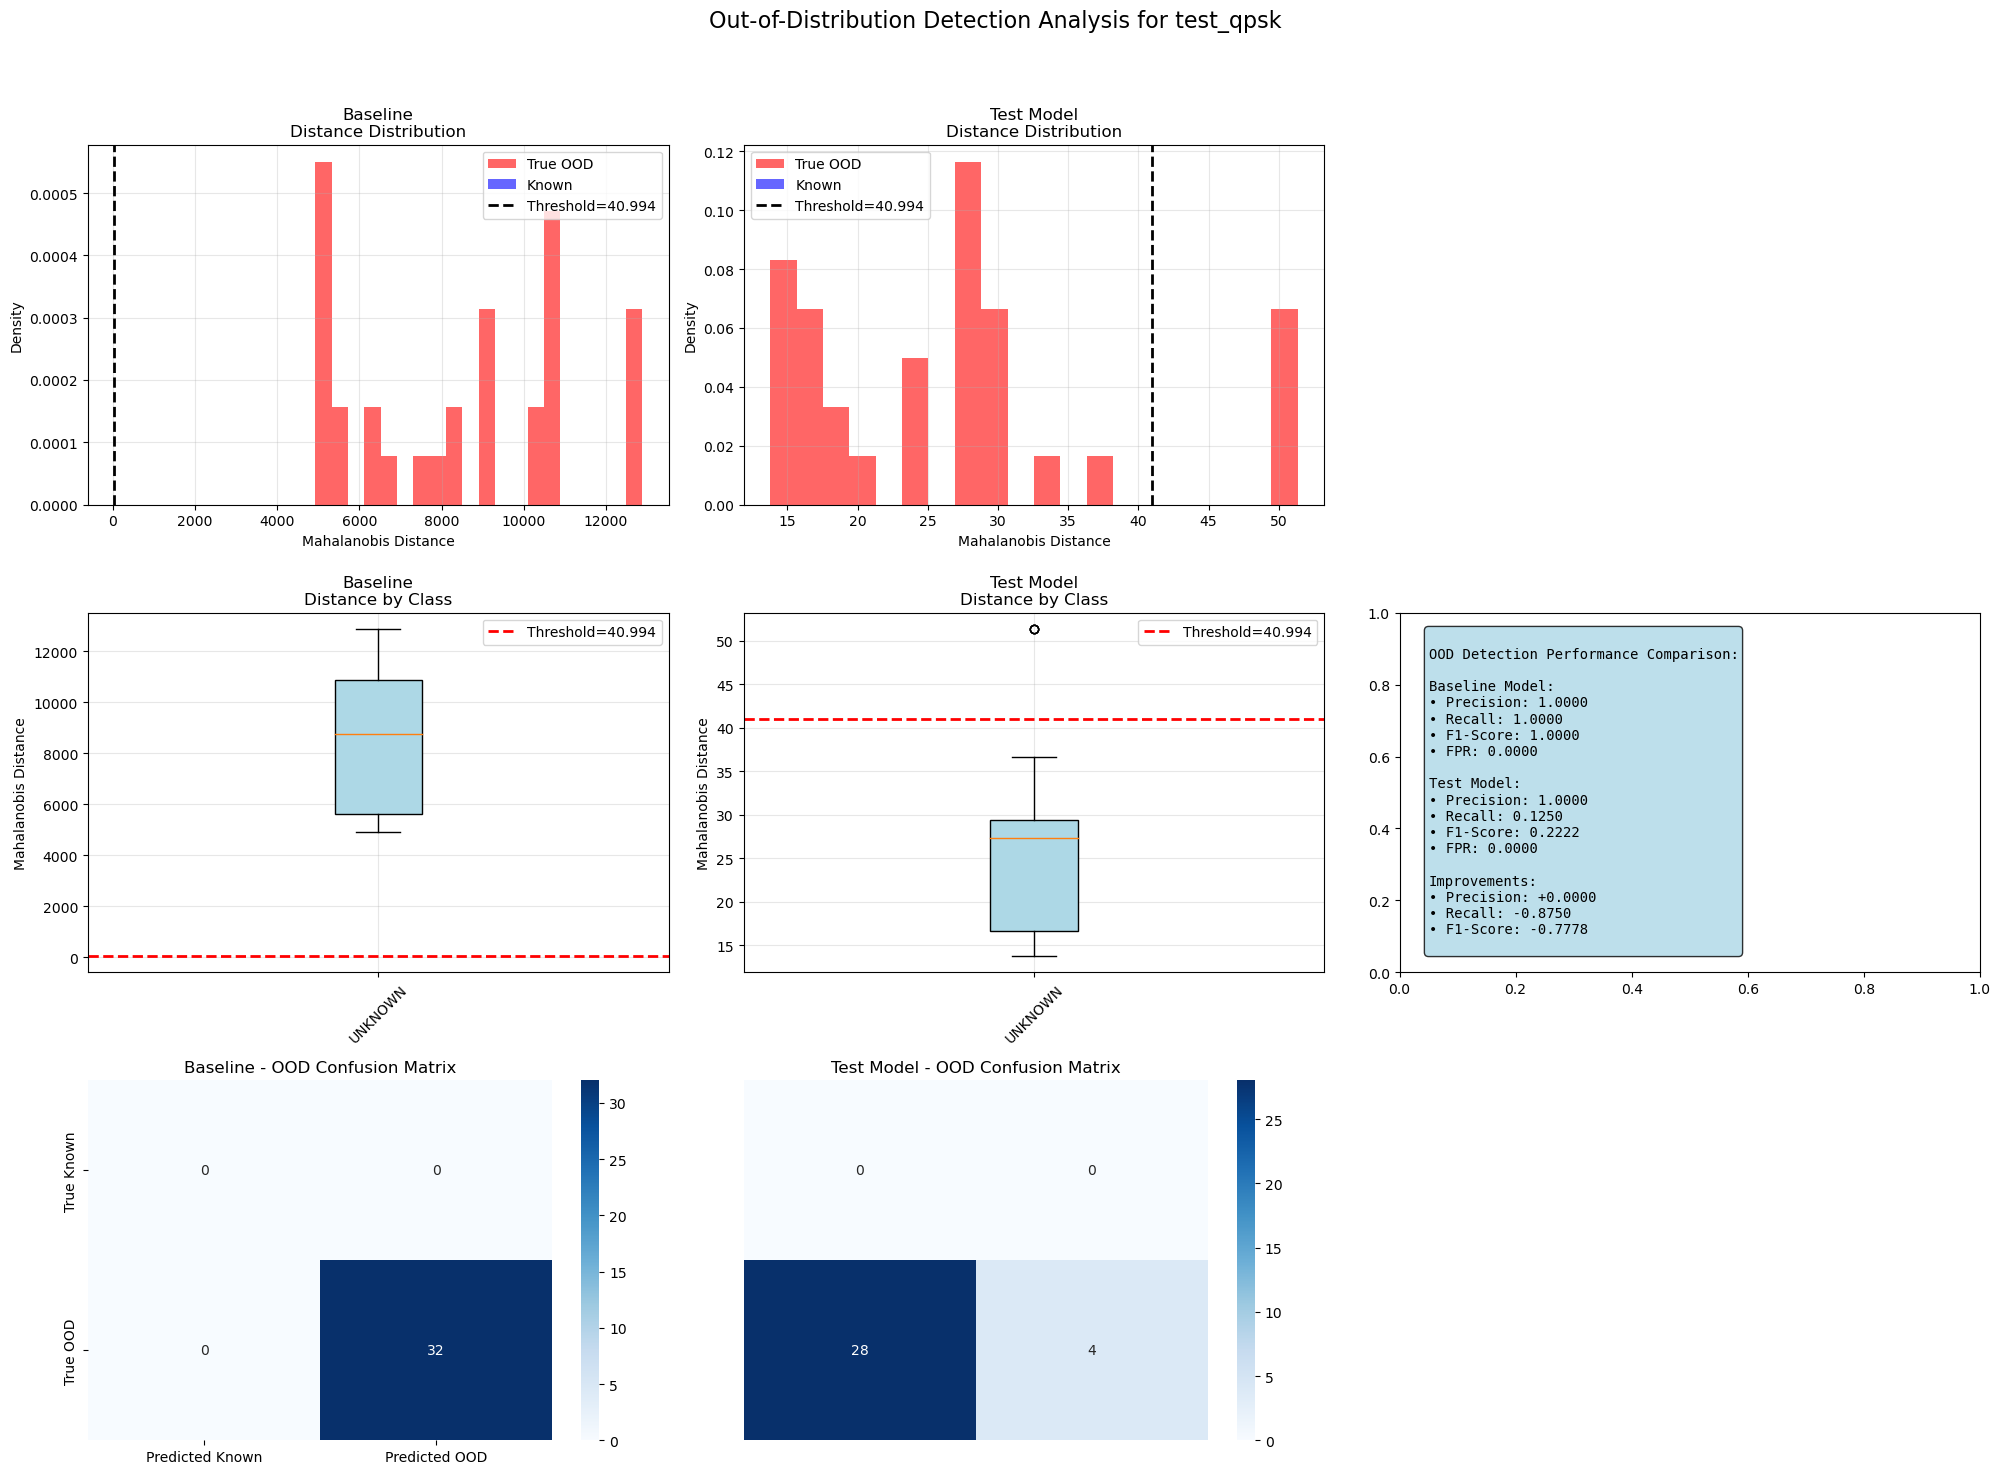

📊 OOD detection visualization completed!


In [165]:
# Visualize OOD Detection Results

if baseline_ood_results is not None and test_ood_results is not None:
    
    plt.figure(figsize=(20, 15))
    plt.suptitle(f'Out-of-Distribution Detection Analysis for {test_folder}', fontsize=16, y=0.98)
    
    # Prepare data for visualization
    models_data = [
        ("Baseline", baseline_ood_results, baseline_test_features),
        ("Test Model", test_ood_results, test_test_features)
    ]
    
    for idx, (model_name, ood_results, features) in enumerate(models_data):
        base_row = idx * 2
        
        # 1. Distance distribution comparison (Known vs OOD)
        plt.subplot(3, 3, idx + 1)
        
        true_ood = ood_results['true_ood']
        distances = ood_results['distances']
        threshold = ood_detector.threshold
        
        # Plot histograms for known vs OOD samples
        known_distances = distances[~true_ood]
        if np.sum(true_ood) > 0:
            ood_distances = distances[true_ood]
            plt.hist(ood_distances, bins=20, alpha=0.6, label='True OOD', color='red', density=True)
        
        plt.hist(known_distances, bins=20, alpha=0.6, label='Known', color='blue', density=True)
        plt.axvline(threshold, color='black', linestyle='--', linewidth=2, 
                    label=f'Threshold={threshold:.3f}')
        
        plt.xlabel('Mahalanobis Distance')
        plt.ylabel('Density')
        plt.title(f'{model_name}\nDistance Distribution')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 3. Per-class distance box plots
        plt.subplot(3, 3, idx + 3 + 1)
        
        class_distances_list = []
        class_labels_list = []
        
        for i, class_name in enumerate(tags):
            class_mask = true_classes == i
            if np.sum(class_mask) > 0:
                class_distances_list.append(distances[class_mask])
                class_labels_list.append(class_name)
        
        if class_distances_list:
            box_plot = plt.boxplot(class_distances_list, labels=class_labels_list, patch_artist=True)
            
            # Color boxes differently for known vs unknown
            colors = ['lightblue', 'lightblue', 'lightblue', 'lightcoral']
            for patch, color in zip(box_plot['boxes'], colors[:len(box_plot['boxes'])]):
                patch.set_facecolor(color)
            
            plt.axhline(threshold, color='red', linestyle='--', linewidth=2,
                       label=f'Threshold={threshold:.3f}')
            plt.ylabel('Mahalanobis Distance')
            plt.title(f'{model_name}\nDistance by Class')
            plt.xticks(rotation=45)
            plt.legend()
            plt.grid(True, alpha=0.3)
    

    
    # 6. Confusion matrices for OOD detection
    plt.subplot(3, 3, 7)
    baseline_cm_ood = np.array([
        [baseline_ood_results['metrics']['tn'], baseline_ood_results['metrics']['fp']],
        [baseline_ood_results['metrics']['fn'], baseline_ood_results['metrics']['tp']]
    ])
    sns.heatmap(baseline_cm_ood, annot=True, fmt='d', cmap='Blues', 
               xticklabels=['Predicted Known', 'Predicted OOD'],
               yticklabels=['True Known', 'True OOD'])
    plt.title('Baseline - OOD Confusion Matrix')
    
    plt.subplot(3, 3, 8)
    test_cm_ood = np.array([
        [test_ood_results['metrics']['tn'], test_ood_results['metrics']['fp']],
        [test_ood_results['metrics']['fn'], test_ood_results['metrics']['tp']]
    ])
    sns.heatmap(test_cm_ood, annot=True, fmt='d', cmap='Blues',
               xticklabels=['Predicted Known', 'Predicted OOD'],
               yticklabels=['True Known', 'True OOD'])
    plt.title('Test Model - OOD Confusion Matrix')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
        # 5. Overall comparison metrics
    plt.axis('off')
    
    plt.subplot(3, 3, 6)
    comparison_text = f"""
OOD Detection Performance Comparison:

Baseline Model:
• Precision: {baseline_ood_results['metrics']['precision']:.4f}
• Recall: {baseline_ood_results['metrics']['recall']:.4f}
• F1-Score: {baseline_ood_results['metrics']['f1_score']:.4f}
• FPR: {baseline_ood_results['metrics']['fpr']:.4f}

Test Model:
• Precision: {test_ood_results['metrics']['precision']:.4f}
• Recall: {test_ood_results['metrics']['recall']:.4f}
• F1-Score: {test_ood_results['metrics']['f1_score']:.4f}
• FPR: {test_ood_results['metrics']['fpr']:.4f}

Improvements:
• Precision: {test_ood_results['metrics']['precision'] - baseline_ood_results['metrics']['precision']:+.4f}
• Recall: {test_ood_results['metrics']['recall'] - baseline_ood_results['metrics']['recall']:+.4f}
• F1-Score: {test_ood_results['metrics']['f1_score'] - baseline_ood_results['metrics']['f1_score']:+.4f}
    """
    
    plt.text(0.05, 0.95, comparison_text, transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    plt.show()
    
    print("📊 OOD detection visualization completed!")
    
else:
    print("📊 Skipping OOD detection visualization - results not available")

In [153]:
# Save OOD Detection and Hybrid Classification Results

if baseline_ood_results is not None and test_ood_results is not None and hybrid_results is not None:
    
    print("=" * 80)
    print("SAVING OOD DETECTION & HYBRID CLASSIFICATION RESULTS")
    print("=" * 80)
    
    import json
    import os
    from datetime import datetime
    
    # Create results directory if it doesn't exist
    results_dir = 'results'
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
        print(f"✅ Created results directory: {results_dir}")
    
    # Prepare comprehensive results dictionary
    prediction_results = {
        'experiment_info': {
            'timestamp': datetime.now().isoformat(),
            'signal_types': tags,
            'test_samples': int(len(true_classes)),
            'baseline_model_path': 'models/baseline_resnet_signal_classifier.h5',
            'test_model_path': 'models/test_resnet_signal_classifier.h5'
        },
        'ood_detection': {
            'baseline_model': {
                'detector_file': baseline_ood_results.get('detector_file', 'Unknown'),
                'threshold': float(baseline_ood_results['threshold']),
                'accuracy': float(baseline_ood_results['accuracy']),
                'precision': float(baseline_ood_results['precision']),
                'recall': float(baseline_ood_results['recall']),
                'f1_score': float(baseline_ood_results['f1_score']),
                'auc_roc': float(baseline_ood_results['auc_roc']),
                'total_ood_detected': int(np.sum(baseline_ood_results['ood_predictions'])),
                'per_class_stats': baseline_ood_results['per_class_stats']
            },
            'test_model': {
                'detector_file': test_ood_results.get('detector_file', 'Unknown'),
                'threshold': float(test_ood_results['threshold']),
                'accuracy': float(test_ood_results['accuracy']),
                'precision': float(test_ood_results['precision']),
                'recall': float(test_ood_results['recall']),
                'f1_score': float(test_ood_results['f1_score']),
                'auc_roc': float(test_ood_results['auc_roc']),
                'total_ood_detected': int(np.sum(test_ood_results['ood_predictions'])),
                'per_class_stats': test_ood_results['per_class_stats']
            }
        },
        'hybrid_classification': {
            'baseline_model': hybrid_results['baseline'],
            'test_model': hybrid_results['test']
        },
        'comparison_summary': {
            'ood_detection_improvement': {
                'accuracy': float(test_ood_results['accuracy'] - baseline_ood_results['accuracy']),
                'precision': float(test_ood_results['precision'] - baseline_ood_results['precision']),
                'recall': float(test_ood_results['recall'] - baseline_ood_results['recall']),
                'f1_score': float(test_ood_results['f1_score'] - baseline_ood_results['f1_score']),
                'auc_roc': float(test_ood_results['auc_roc'] - baseline_ood_results['auc_roc'])
            },
            'hybrid_classification_improvement': {
                'baseline_ood_benefit': float(hybrid_results['baseline']['ood_benefit']),
                'test_ood_benefit': float(hybrid_results['test']['ood_benefit']),
                'model_improvement': float(hybrid_results['test']['hybrid_accuracy'] - hybrid_results['baseline']['hybrid_accuracy'])
            }
        }
    }
    
    # Save main results file
    results_filename = f"{results_dir}/ood_prediction_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
    
    # Convert numpy arrays to lists for JSON serialization
    def convert_numpy_types(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, dict):
            return {key: convert_numpy_types(value) for key, value in obj.items()}
        elif isinstance(obj, list):
            return [convert_numpy_types(item) for item in obj]
        else:
            return obj
    
    prediction_results = convert_numpy_types(prediction_results)
    
    try:
        with open(results_filename, 'w') as f:
            json.dump(prediction_results, f, indent=2)
        print(f"✅ Saved comprehensive results to: {results_filename}")
    except Exception as e:
        print(f"❌ Error saving results: {e}")
    
    # Save detailed predictions for further analysis
    detailed_predictions = {
        'true_labels': true_classes.tolist(),
        'baseline_model': {
            'original_predictions': predicted_classes_baseline.tolist(),
            'hybrid_predictions': hybrid_results['baseline']['hybrid_predictions'].tolist(),
            'ood_predictions': baseline_ood_results['ood_predictions'].tolist(),
            'ood_distances': baseline_ood_results['distances'].tolist()
        },
        'test_model': {
            'original_predictions': predicted_classes_test.tolist(),
            'hybrid_predictions': hybrid_results['test']['hybrid_predictions'].tolist(),
            'ood_predictions': test_ood_results['ood_predictions'].tolist(),
            'ood_distances': test_ood_results['distances'].tolist()
        }
    }
    
    predictions_filename = f"{results_dir}/detailed_predictions_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
    
    try:
        with open(predictions_filename, 'w') as f:
            json.dump(detailed_predictions, f, indent=2)
        print(f"✅ Saved detailed predictions to: {predictions_filename}")
    except Exception as e:
        print(f"❌ Error saving detailed predictions: {e}")
    
    # Print summary of what was saved
    print(f"\n📊 Results Summary:")
    print(f"   • Main results file: {results_filename}")
    print(f"   • Detailed predictions: {predictions_filename}")
    print(f"   • Test samples analyzed: {len(true_classes):,}")
    print(f"   • Signal types: {', '.join(tags)}")
    
    # Print key findings
    print(f"\n🔍 Key Findings:")
    ood_acc_improvement = test_ood_results['accuracy'] - baseline_ood_results['accuracy']
    hybrid_acc_improvement = hybrid_results['test']['hybrid_accuracy'] - hybrid_results['baseline']['hybrid_accuracy']
    
    print(f"   • OOD Detection Accuracy Improvement: {ood_acc_improvement:+.4f}")
    print(f"   • Hybrid Classification Improvement: {hybrid_acc_improvement:+.4f}")
    print(f"   • Best OOD Detection F1-Score: {max(baseline_ood_results['f1_score'], test_ood_results['f1_score']):.4f}")
    print(f"   • Best Hybrid Classification Accuracy: {max(hybrid_results['baseline']['hybrid_accuracy'], hybrid_results['test']['hybrid_accuracy']):.4f}")
    
    if ood_acc_improvement > 0.01:
        print(f"   ✅ Test model shows significant OOD detection improvement")
    if hybrid_acc_improvement > 0.01:
        print(f"   ✅ Test model shows significant hybrid classification improvement")
    
    print(f"\n✅ All OOD detection and hybrid classification results saved successfully!")
    
else:
    print("❌ Skipping results saving - required results not available")
    print("   Missing one or more of: baseline_ood_results, test_ood_results, hybrid_results")

NameError: name 'hybrid_results' is not defined

## K Means Clustering

In [ ]:
true_label

NameError: name 'true_labels' is not defined

In [211]:
# K-Means Clustering Analysis on Penultimate Layer Features

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

print("=" * 80)
print("K-MEANS CLUSTERING ANALYSIS ON NEURAL NETWORK FEATURES")
print("=" * 80)

def perform_clustering_analysis(features, true_labels, model_name, k_range=(3, 6)):
    """
    Perform k-means clustering analysis on feature vectors.
    
    Args:
        features: Feature vectors from penultimate layer
        true_labels: Ground truth labels for comparison
        model_name: Name of the model for reporting
        k_range: Range of k values to try (min, max)
    
    Returns:
        dict: Results containing optimal k and clustering metrics
    """
    
    print(f"\n{'='*60}")
    print(f"CLUSTERING ANALYSIS - {model_name}")
    print(f"{'='*60}")
    
    # Standardize features for better clustering
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    print(f"Feature shape: {features.shape}")
    print(f"Standardized features - Mean: {np.mean(features_scaled):.6f}, Std: {np.std(features_scaled):.6f}")
    
    # Test different k values
    k_values = list(range(k_range[0], k_range[1] + 1))
    results = []
    
    print(f"\nTesting k values: {k_values}")
    print(f"{'k':<3} {'Inertia':<12} {'Silhouette':<12} {'ARI':<8} {'NMI':<8}")
    print("-" * 50)
    
    best_k = k_values[0]
    best_silhouette = -1
    best_kmeans = None
    
    for k in k_values:
        # Perform k-means clustering
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(features_scaled)
        
        # Calculate clustering metrics
        inertia = kmeans.inertia_
        silhouette = silhouette_score(features_scaled, cluster_labels)
        
        # Compare with true labels (if available)
        if len(np.unique(true_labels)) > 1:
            ari = adjusted_rand_score(true_labels, cluster_labels)
            nmi = normalized_mutual_info_score(true_labels, cluster_labels)
        else:
            ari = 0.0
            nmi = 0.0
        
        print(f"{k:<3} {inertia:<12.2f} {silhouette:<12.4f} {ari:<8.4f} {nmi:<8.4f}")
        
        # Track best k based on silhouette score
        if silhouette > best_silhouette:
            best_silhouette = silhouette
            best_k = k
            best_kmeans = kmeans
        
        results.append({
            'k': k,
            'inertia': inertia,
            'silhouette_score': silhouette,
            'adjusted_rand_index': ari,
            'normalized_mutual_info': nmi,
            'cluster_labels': cluster_labels,
            'kmeans_model': kmeans
        })
    
    print(f"\n🎯 BEST CLUSTERING RESULT:")
    print(f"   Optimal k: {best_k}")
    print(f"   Best silhouette score: {best_silhouette:.4f}")
    
    # Analyze best clustering
    best_result = next(r for r in results if r['k'] == best_k)
    best_labels = best_result['cluster_labels']
    
    print(f"\n📊 CLUSTER ANALYSIS (k={best_k}):")
    
    # Cluster size distribution
    unique_clusters, cluster_counts = np.unique(best_labels, return_counts=True)
    for cluster_id, count in zip(unique_clusters, cluster_counts):
        percentage = (count / len(best_labels)) * 100
        print(f"   Cluster {cluster_id}: {count} samples ({percentage:.1f}%)")
    
    # Compare clusters with true signal classes
    if len(np.unique(true_labels)) > 1:
        print(f"\n🔍 CLUSTER vs TRUE LABEL ANALYSIS:")
        
        # Create confusion matrix between clusters and true labels
        from sklearn.metrics import confusion_matrix
        
        # Only consider known signal classes (exclude UNKNOWN)
        # known_mask = true_labels < 3  # Assuming UNKNOWN is class 3
        # if np.sum(known_mask) > 0:
        if True:
            cm = confusion_matrix(true_labels, best_labels)
            # cm = confusion_matrix(true_labels[known_mask], best_labels[known_mask])
            
            print(f"   Confusion Matrix (Clusters vs True Labels):")
            signal_names = ['16QAM', '8CPSK', 'FM', 'UNKNOWN']
            
            # Print header
            header = "True\\Pred  " + "  ".join([f"C{i}" for i in range(best_k)])
            print(f"   {header}")
            
            # Print matrix
            for i, signal_name in enumerate(signal_names):
                if i < cm.shape[0]:
                    row = f"   {signal_name:<8}  " + "  ".join([f"{cm[i,j]:>2}" for j in range(min(best_k, cm.shape[1]))])
                    print(row)
    
    return {
        'results': results,
        'best_k': best_k,
        'best_silhouette': best_silhouette,
        'best_kmeans': best_kmeans,
        'best_labels': best_labels,
        'features_scaled': features_scaled,
        'scaler': scaler
    }

def visualize_clustering_results(clustering_results, model_name, true_labels):
    """
    Visualize clustering results with multiple plots.
    """
    
    results = clustering_results['results']
    best_k = clustering_results['best_k']
    best_labels = clustering_results['best_labels']
    print(best_labels)
    features_scaled = clustering_results['features_scaled']
    
    # Create comprehensive visualization
    plt.figure(figsize=(20, 15))
    plt.suptitle(f'K-Means Clustering Analysis - {model_name}', fontsize=16, y=0.98)
    
    # Plot 1: Elbow curve (Inertia vs k)
    plt.subplot(3, 4, 1)
    k_values = [r['k'] for r in results]
    inertias = [r['inertia'] for r in results]
    
    plt.plot(k_values, inertias, 'bo-', linewidth=2, markersize=8)
    plt.axvline(best_k, color='red', linestyle='--', label=f'Optimal k={best_k}')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia (Within-cluster Sum of Squares)')
    plt.title('Elbow Method')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Silhouette score vs k
    plt.subplot(3, 4, 2)
    silhouette_scores = [r['silhouette_score'] for r in results]
    
    plt.plot(k_values, silhouette_scores, 'go-', linewidth=2, markersize=8)
    plt.axvline(best_k, color='red', linestyle='--', label=f'Optimal k={best_k}')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Analysis')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 3: ARI and NMI vs k
    plt.subplot(3, 4, 3)
    ari_scores = [r['adjusted_rand_index'] for r in results]
    nmi_scores = [r['normalized_mutual_info'] for r in results]
    
    plt.plot(k_values, ari_scores, 'ro-', linewidth=2, label='ARI', markersize=6)
    plt.plot(k_values, nmi_scores, 'bo-', linewidth=2, label='NMI', markersize=6)
    plt.axvline(best_k, color='black', linestyle='--', alpha=0.7, label=f'Optimal k={best_k}')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Score')
    plt.title('External Validation Metrics')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Cluster size distribution for optimal k
    plt.subplot(3, 4, 4)
    unique_clusters, cluster_counts = np.unique(best_labels, return_counts=True)
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_clusters)))
    bars = plt.bar(unique_clusters, cluster_counts, color=colors, alpha=0.8, edgecolor='black')
    
    # Add count labels on bars
    for bar, count in zip(bars, cluster_counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                str(count), ha='center', va='bottom', fontweight='bold')
    
    plt.xlabel('Cluster ID')
    plt.ylabel('Number of Samples')
    plt.title(f'Cluster Size Distribution (k={best_k})')
    plt.grid(True, alpha=0.3)
    
    # Plot 5-8: 2D PCA visualization for different k values
    pca = PCA(n_components=2, random_state=42)
    features_pca = pca.fit_transform(features_scaled)
    
    for i, k in enumerate([3, 4, 5, 6]):
        if k <= max(k_values):
            plt.subplot(3, 4, 5 + i)
            
            # Get clustering result for this k
            k_result = next((r for r in results if r['k'] == k), None)
            if k_result is not None:
                labels = k_result['cluster_labels']
                
                # Plot clusters
                scatter = plt.scatter(features_pca[:, 0], features_pca[:, 1], 
                                    c=labels, cmap='Set3', alpha=0.7, s=30, edgecolors='black', linewidth=0.5)
                
                # Plot cluster centers in PCA space
                kmeans_model = k_result['kmeans_model']
                centers_pca = pca.transform(kmeans_model.cluster_centers_)
                plt.scatter(centers_pca[:, 0], centers_pca[:, 1], 
                          c='red', marker='x', s=200, linewidths=3, label='Centroids')
                
                plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
                plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
                plt.title(f'PCA Visualization (k={k})')
                
                if k == best_k:
                    plt.title(f'PCA Visualization (k={k}) ⭐ BEST', fontweight='bold')
                
                plt.legend()
                plt.grid(True, alpha=0.3)
    
    # Plot 9: True labels vs best clustering (if available)
    plt.subplot(3, 4, 9)
    if len(np.unique(true_labels)) > 1:
        # Create side-by-side comparison
        fig_width = 0.35
        
        # True labels
        known_mask = true_labels < 3  # Exclude UNKNOWN class
        if np.sum(known_mask) > 0:
            plt.scatter(features_pca[known_mask, 0] - 0.5, features_pca[known_mask, 1], 
                       c=true_labels[known_mask], cmap='viridis', alpha=0.7, s=30, 
                       edgecolors='black', linewidth=0.5, label='True Labels')
            
            # Best clustering
            plt.scatter(features_pca[known_mask, 0] + 0.5, features_pca[known_mask, 1], 
                       c=best_labels[known_mask], cmap='Set3', alpha=0.7, s=30,
                       edgecolors='black', linewidth=0.5, label='Clusters')
            
            plt.xlabel('PC1 (shifted for comparison)')
            plt.ylabel('PC2')
            plt.title('True Labels vs Clusters')
            plt.legend()
            plt.grid(True, alpha=0.3)
        else:
            plt.text(0.5, 0.5, 'No known class\nlabels available', 
                    ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
            plt.title('True Labels vs Clusters')
    
    # Plot 10: Metrics summary
    plt.subplot(3, 4, 10)
    plt.axis('off')
    
    metrics_text = f"""
Clustering Results Summary:

Optimal k: {best_k}
Best Silhouette Score: {clustering_results['best_silhouette']:.4f}

All k Results:
"""
    
    for r in results:
        metrics_text += f"k={r['k']}: Sil={r['silhouette_score']:.3f}, ARI={r['adjusted_rand_index']:.3f}\n"
    
    metrics_text += f"""
Feature Information:
• Original features: {features_scaled.shape[1]}
• PCA variance explained: {pca.explained_variance_ratio_[:2].sum():.2%}
• Standardization: Applied
    """
    
    plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


K-MEANS CLUSTERING ANALYSIS ON NEURAL NETWORK FEATURES


In [204]:
best_labels

NameError: name 'best_labels' is not defined

In [210]:
true_classes

array([3, 2, 2, 0, 2, 0, 3, 2, 0, 1, 0, 0, 1, 0, 1, 0, 1, 3, 2, 1, 2, 3,
       0, 3, 1, 1, 3, 0, 0, 2, 1, 1, 2, 1, 2, 0, 3, 0, 2, 1, 3, 2, 0, 3,
       3, 2, 3, 0, 2, 3, 1, 2], dtype=int64)

🔍 Analyzing BASELINE MODEL features...

CLUSTERING ANALYSIS - BASELINE MODEL
Feature shape: (52, 128)
Standardized features - Mean: 0.000000, Std: 0.690335

Testing k values: [3, 4, 5, 6]
k   Inertia      Silhouette   ARI      NMI     
--------------------------------------------------
3   1537.31      0.3697       0.0028   0.0711  


c:\Users\UserAdmin\miniconda3\envs\new_tf_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\UserAdmin\miniconda3\envs\new_tf_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


4   1132.33      0.2704       0.0796   0.1890  
5   969.24       0.2877       0.0900   0.2345  
6   872.53       0.2000       0.0963   0.2503  

🎯 BEST CLUSTERING RESULT:
   Optimal k: 3
   Best silhouette score: 0.3697

📊 CLUSTER ANALYSIS (k=3):
   Cluster 0: 9 samples (17.3%)
   Cluster 1: 41 samples (78.8%)
   Cluster 2: 2 samples (3.8%)

🔍 CLUSTER vs TRUE LABEL ANALYSIS:
   Confusion Matrix (Clusters vs True Labels):
   True\Pred  C0  C1  C2
   16QAM      1  12   1
   8CPSK      1  11   0
   FM         5   9   0
   UNKNOWN    2   9   1

📊 Visualizing baseline model clustering...
[1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1
 1 1 1 1 0 1 1 1 1 1 2 1 2 1 1]


c:\Users\UserAdmin\miniconda3\envs\new_tf_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\UserAdmin\miniconda3\envs\new_tf_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\UserAdmin\AppData\Local\Temp\ipykernel_27016\522007748.py:299: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
C:\Users\UserAdmin\AppData\Local\Temp\ipykernel_27016\522007748.py:299: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
c:\U

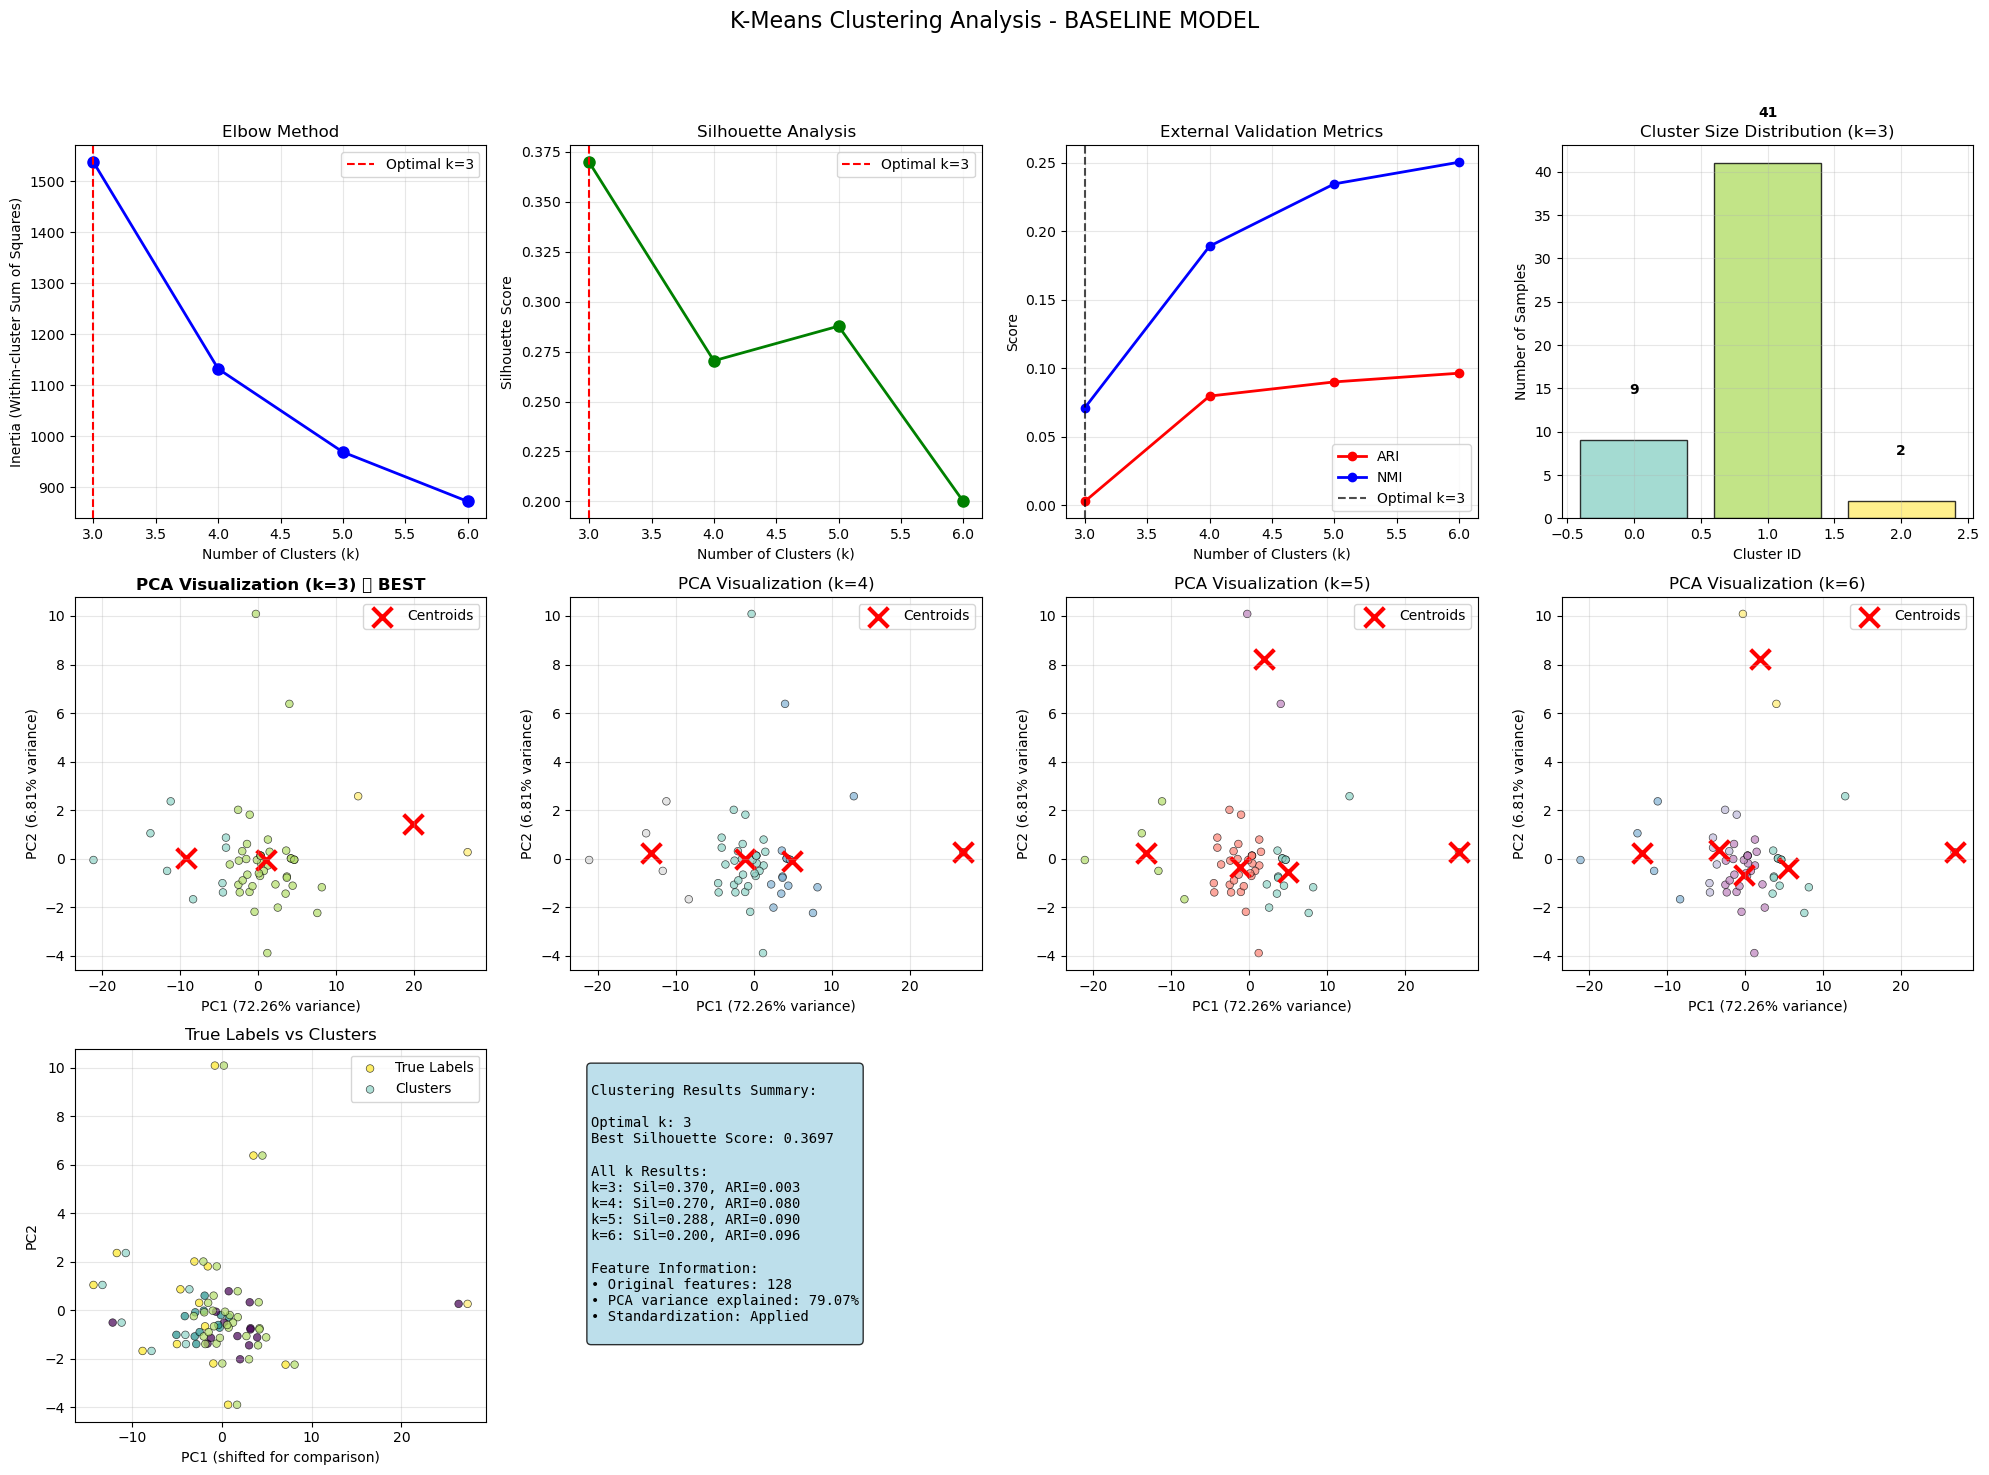


🔍 Analyzing TEST MODEL features...

CLUSTERING ANALYSIS - TEST MODEL
Feature shape: (52, 128)
Standardized features - Mean: 0.000000, Std: 0.984251

Testing k values: [3, 4, 5, 6]
k   Inertia      Silhouette   ARI      NMI     
--------------------------------------------------
3   4204.63      0.2157       0.6634   0.7618  
4   3796.88      0.2313       0.6446   0.7116  


c:\Users\UserAdmin\miniconda3\envs\new_tf_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\UserAdmin\miniconda3\envs\new_tf_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\UserAdmin\miniconda3\envs\new_tf_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


5   3352.23      0.1670       0.7704   0.7983  
6   3037.72      0.2047       0.6657   0.7375  

🎯 BEST CLUSTERING RESULT:
   Optimal k: 4
   Best silhouette score: 0.2313

📊 CLUSTER ANALYSIS (k=4):
   Cluster 0: 2 samples (3.8%)
   Cluster 1: 13 samples (25.0%)
   Cluster 2: 19 samples (36.5%)
   Cluster 3: 18 samples (34.6%)

🔍 CLUSTER vs TRUE LABEL ANALYSIS:
   Confusion Matrix (Clusters vs True Labels):
   True\Pred  C0  C1  C2  C3
   16QAM      0   0  14   0
   8CPSK      0  12   0   0
   FM         0   0   0  14
   UNKNOWN    2   1   5   4

📊 Visualizing test model clustering...
[2 3 3 2 3 2 1 3 2 1 2 2 1 2 1 2 1 3 3 1 3 3 2 2 1 1 3 2 2 3 1 1 3 1 3 2 2
 2 3 1 3 3 2 2 0 3 2 2 3 0 1 3]


c:\Users\UserAdmin\miniconda3\envs\new_tf_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\UserAdmin\AppData\Local\Temp\ipykernel_27016\522007748.py:299: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
C:\Users\UserAdmin\AppData\Local\Temp\ipykernel_27016\522007748.py:299: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
c:\Users\UserAdmin\miniconda3\envs\new_tf_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\UserAdmin\miniconda3\envs\new_tf_env\lib\site-packages\IPython\core\pylabtools.py:152: Use

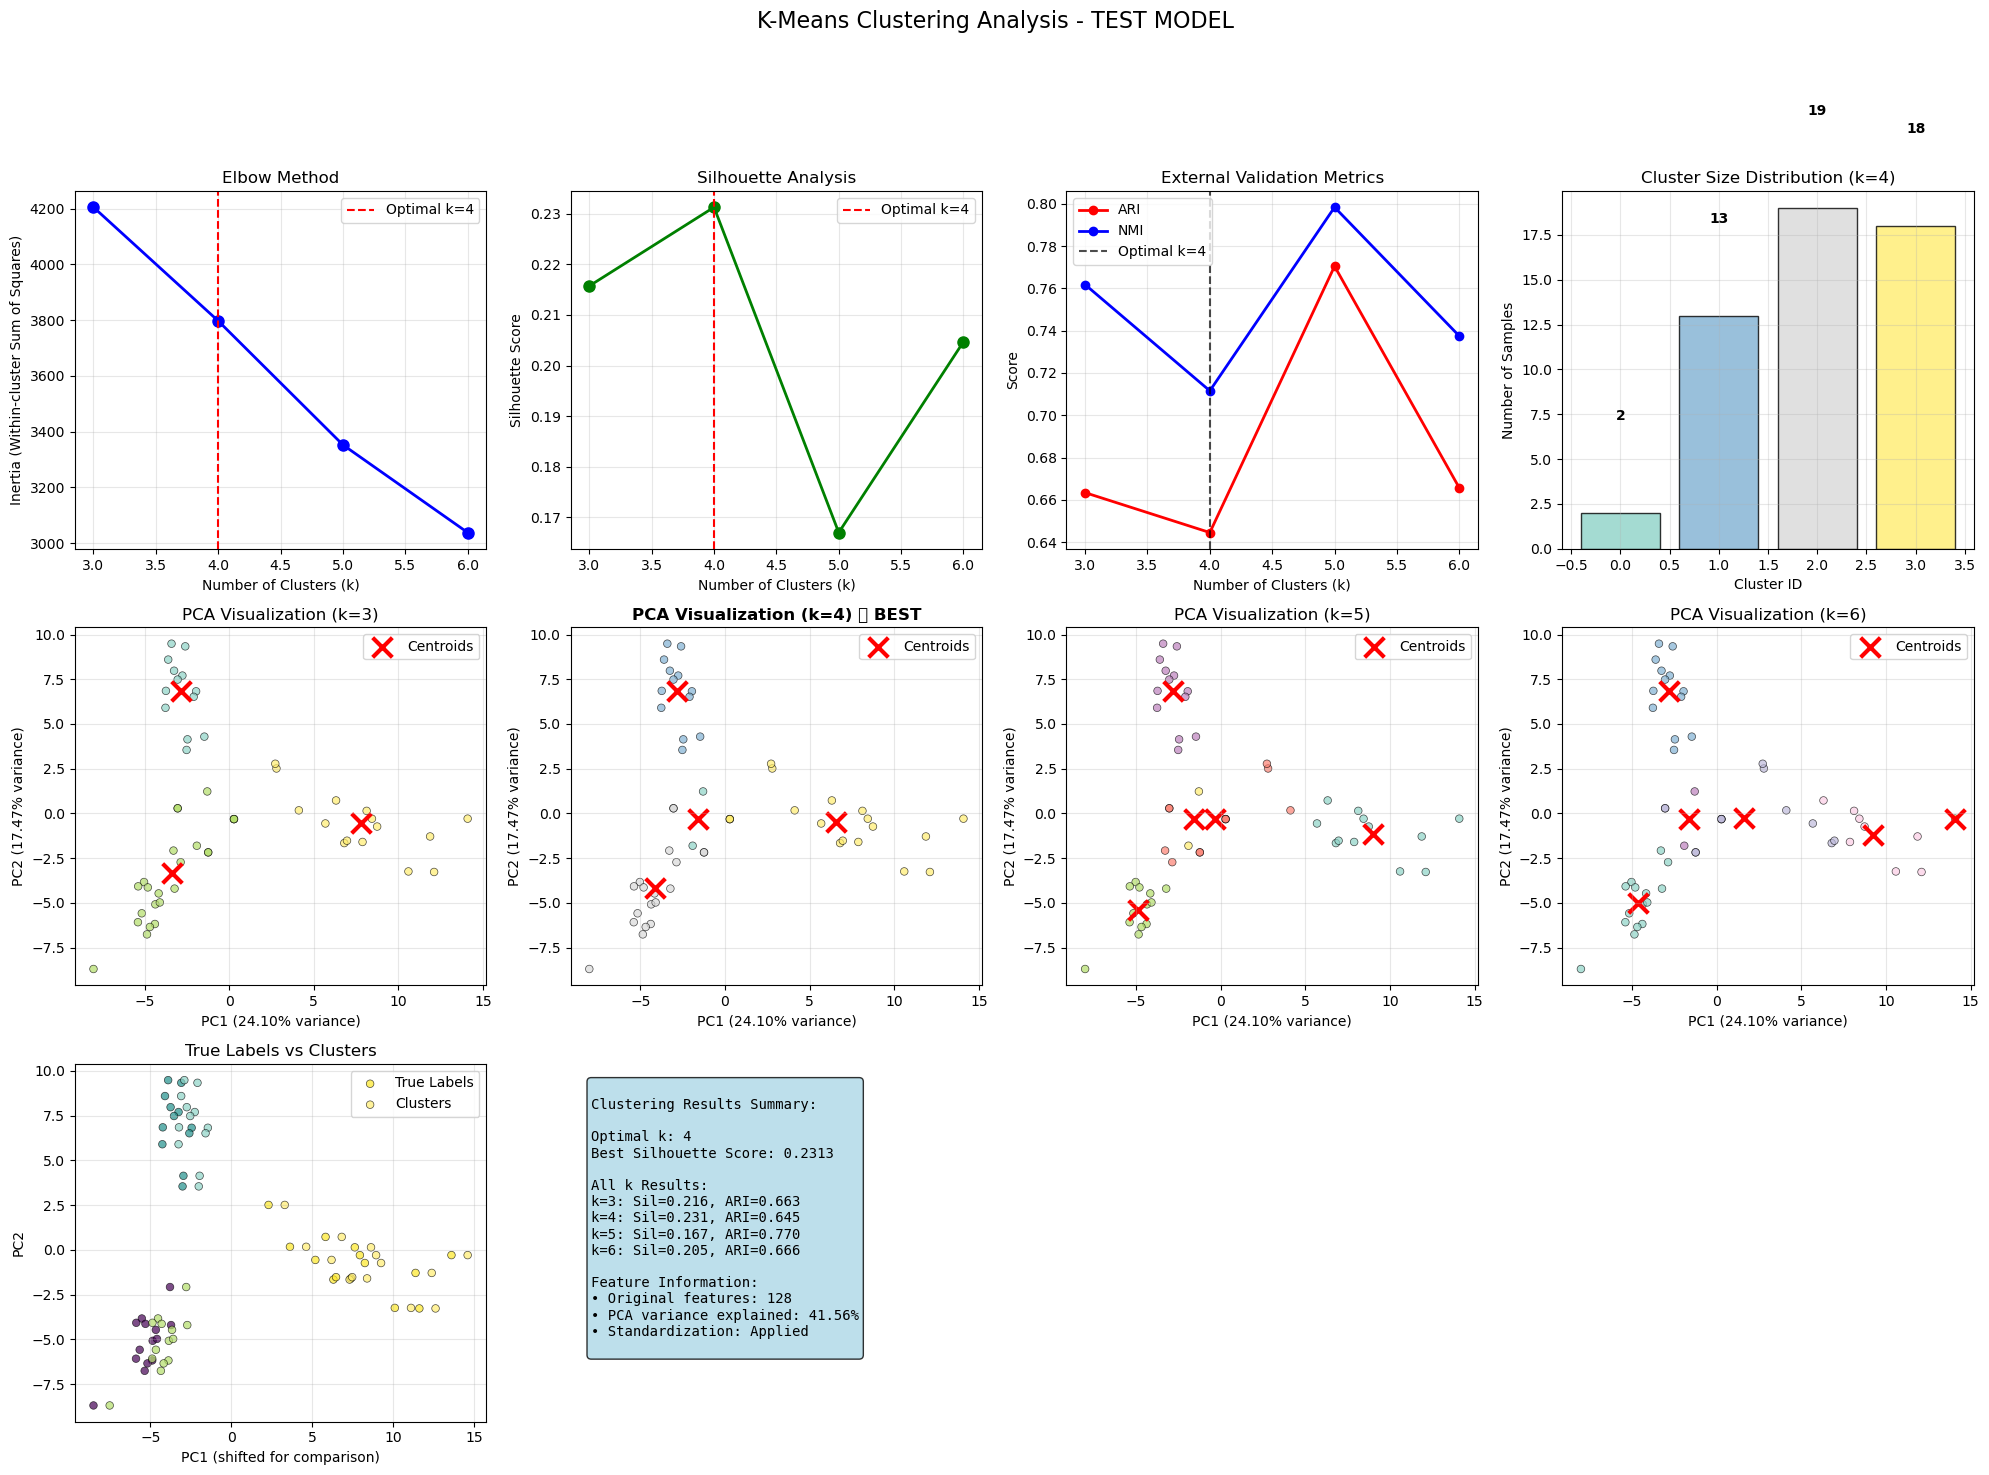


CLUSTERING COMPARISON BETWEEN MODELS
Baseline Model:
  • Optimal k: 3
  • Best silhouette: 0.3697

Test Model:
  • Optimal k: 4
  • Best silhouette: 0.2313

Comparison:
  ⚠️  Baseline model shows better clustering structure (+0.1384)
  🔄 Models suggest different k values: baseline=3, test=4

✅ K-means clustering analysis completed!


In [212]:

# Perform clustering analysis on both models (if features are available)
clustering_results = {}

if 'baseline_test_features' in locals() and baseline_test_features is not None:
    print("🔍 Analyzing BASELINE MODEL features...")
    clustering_results['baseline'] = perform_clustering_analysis(
        baseline_test_features, true_classes, "BASELINE MODEL"
    )
    
    print("\n📊 Visualizing baseline model clustering...")
    visualize_clustering_results(clustering_results['baseline'], "BASELINE MODEL", true_classes)

if 'test_test_features' in locals() and test_test_features is not None:
    print("\n🔍 Analyzing TEST MODEL features...")
    clustering_results['test'] = perform_clustering_analysis(
        test_test_features, true_classes, "TEST MODEL"
    )
    
    print("\n📊 Visualizing test model clustering...")
    visualize_clustering_results(clustering_results['test'], "TEST MODEL", true_classes)

# Comparison between models (if both available)
if len(clustering_results) == 2:
    print(f"\n{'='*80}")
    print("CLUSTERING COMPARISON BETWEEN MODELS")
    print(f"{'='*80}")
    
    baseline_best = clustering_results['baseline']['best_k']
    test_best = clustering_results['test']['best_k']
    baseline_sil = clustering_results['baseline']['best_silhouette']
    test_sil = clustering_results['test']['best_silhouette']
    
    print(f"Baseline Model:")
    print(f"  • Optimal k: {baseline_best}")
    print(f"  • Best silhouette: {baseline_sil:.4f}")
    
    print(f"\nTest Model:")
    print(f"  • Optimal k: {test_best}")
    print(f"  • Best silhouette: {test_sil:.4f}")
    
    print(f"\nComparison:")
    if test_sil > baseline_sil:
        print(f"  ✅ Test model shows better clustering structure (+{test_sil - baseline_sil:.4f})")
    elif baseline_sil > test_sil:
        print(f"  ⚠️  Baseline model shows better clustering structure (+{baseline_sil - test_sil:.4f})")
    else:
        print(f"  ➖ Both models show similar clustering structure")
    
    if test_best == baseline_best:
        print(f"  🎯 Both models agree on optimal k={test_best}")
    else:
        print(f"  🔄 Models suggest different k values: baseline={baseline_best}, test={test_best}")

print(f"\n✅ K-means clustering analysis completed!")